# Table of Contents
1. [Data Cleaning](#data-cleaning)
2. [Basic Feature Engineering](#feature-engineering)
    1. [Custom One-Hot Encoding Function for Generated Data](#one-hot-enc)
3. [Initial KNN Regression Implementation and Error Rate Visualization](#initial-knn)
4. [Running All Regression Models on Data with Train-Test Split](#initial-regression-model-run)
    1. [Compute RMSE Model List Function](#compute-rmse)
5. [Using 2017 Data as Testing Data and everything else as Training Data](#2017-test-data)
6. [Outlier Analysis](#outlier-analysis)
    1. [Finding Out Outlier Months](#outlier-months)
    2. [Running Compute RMSE Model List after removing Outlier Months from test data](#outlier-months-compute-rmse)
    3. [Finding Out Outlier Days](#outlier-days)
    4. [Finding Out Outlier Days Per ATM](#outlier-day-per-atm)
7. [Model Training Per ATM](#model-training-per-atm)
8. [Model Training On All ATMs but using Individual ATMs as test set](#train-one-model-but-diff-test)
    1. [Model Training On All ATMs but not using KK Nagar and Christ College Data](#no-kk)
9. [Hyperparameter Tuning](#hyperparameter)
    1. [For SVR](#hyperparameter-svr)
    2. [Plotting Validation Curve function](#validation-curve)
    3. [For Lasso (with Validation Curve)](#hyperparameter-lasso)
    4. [For Ridge (with Validation Curve)](#hyperparameter-ridge)
    5. [For Elasticnet](#hyperparameter-enet)
    6. [For Bayesian Ridge](#hyperparameter-bayes)
    7. [For KNN](#hyperparameter-knn)
    8. [For Decision Tree](#hyperparameter-dtree)
    9. [For Random Forest](#hyperparameter-rforest)
10. [Polynomial Regression with Hyperparameter Tuning](#polynomial)
    

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 

%matplotlib inline

In [47]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve, cross_val_score, train_test_split

from sklearn.pipeline import Pipeline

# For measuring feature importance in tree based models like DTree and RandomForest
from sklearn.inspection import permutation_importance 
# For measuring feature importance in linear_models like Lasso, Ridge, etc.
from regressors.stats import coef_pval

<a name="data-cleaning"></a>
## Data Import and Cleaning 
<p> The function performs the following tasks, </p>
    <ol> 
        <li> Converts Weekday column to Uppercase because of format mismatch </li>
        <li> Converts Transaction Date column to Date Time object </li>
        <li> Removes the XYZ and Other Card Withdrawn Amounts columns target column (Total Amount Withdrawn) is the sum of these two columns </li>
        <li> Removes the Number of XYZ and Other Card Withdrawal columns because we will not know these values for test data</li>

In [3]:
data = pd.read_csv("AggregatedData.csv")
    
def data_import_and_cleaning(data):
    data['Weekday'] = data['Weekday'].str.upper()
    data['Transaction Date'] = pd.to_datetime(data['Transaction Date']) 
    new_data = data.drop(['Transaction Date', 'Amount withdrawn Other Card', 'Amount withdrawn XYZ Card', 
                          'No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals'], 
                         axis=1)
    
    return new_data

new_data = data_import_and_cleaning(data)

In [4]:
new_data.head()

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,123800,SATURDAY,H,H,WHH
1,Mount Road ATM,767900,SATURDAY,C,H,WHH
2,Airport ATM,503400,SATURDAY,C,H,WHH
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH
4,Christ College ATM,287700,SATURDAY,C,H,WHH


<a name="feature-engineering"></a>
## Basic Feature Engineering
<p> The following features are generated here, more can be added later on </p>
<ol>
    <li> Converting Transaction Date to individual columns for day, month and year, otherwise model won't accept it </li>
    <li> One-Hot Encoding the Categorical Columns using the function written below </li>
</ol>

In [5]:
new_data['Month'] = data['Transaction Date'].dt.month
new_data['Day'] = data['Transaction Date'].dt.day
new_data['Year'] = data['Transaction Date'].dt.year

In [6]:
new_data.columns

Index(['ATM Name', 'Total amount Withdrawn', 'Weekday', 'Festival Religion',
       'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year'],
      dtype='object')

<a name="one-hot-enc"></a>
<h3> Custom One-Hot Encoding Function for Generated Data </h3>

In [7]:
categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year']

In [8]:
# Convert all categorical columns to Dummy Data (One-Hot Encoding)
# drop_first = True to avoid the first column of each dummy column's result
# So if column = Gender and has two unique values Male and Female, get_dummies on this column creates two new columns
# male and female, if person male that column is 1 and the other is 0 and same for female column, but we only just need
# one of these columns, male or female, if male is 0 it guarantees person is female, for that reason drop_first=True
def convert_categorical_to_numerical(data, column_list):
    if 'ATM Name' in column_list:
        column_list.remove('ATM Name')
        temp_data = pd.get_dummies(data, columns=column_list , drop_first=True)
    
        # Do drop_first for all columns, except for ATM Name, because it becomes useful for accessing individual ATM test
        # data later on
        return pd.get_dummies(temp_data, columns=['ATM Name'])
    else:
        return pd.get_dummies(data, columns=column_list, drop_first=True)


# One-Hot Encoding and then one of the ATM Name columns has to be dropped because of the way the function is written
temp_numeric_data = convert_categorical_to_numerical(new_data, categorical_features_list)
numeric_data = temp_numeric_data.drop('ATM Name_KK Nagar ATM', axis=1)

In [9]:
numeric_data.head()

,Total amount Withdrawn,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,Weekday_WEDNESDAY,Festival Religion_H,Festival Religion_M,Festival Religion_N,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,ATM Name_Airport ATM,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_Mount Road ATM
0,123800,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,767900,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,503400,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,945300,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<h3> Note that since all columns are non-numeric, scaling is not required</h3>

<a name="initial-knn"></a>
## KNN Implementation & Error Rate Visualization

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

X = numeric_data.drop('Total amount Withdrawn', axis=1)
y = numeric_data['Total amount Withdrawn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

error_rate = []
for k in range(1, 40):
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    error_rate.append(np.sqrt(mean_squared_error(y_test, predictions)))
    print("k={} Model Trained and Tested".format(k))

k=1 Model Trained and Tested
k=2 Model Trained and Tested
k=3 Model Trained and Tested
k=4 Model Trained and Tested
k=5 Model Trained and Tested
k=6 Model Trained and Tested
k=7 Model Trained and Tested
k=8 Model Trained and Tested
k=9 Model Trained and Tested
k=10 Model Trained and Tested
k=11 Model Trained and Tested
k=12 Model Trained and Tested
k=13 Model Trained and Tested
k=14 Model Trained and Tested
k=15 Model Trained and Tested
k=16 Model Trained and Tested
k=17 Model Trained and Tested
k=18 Model Trained and Tested
k=19 Model Trained and Tested
k=20 Model Trained and Tested
k=21 Model Trained and Tested
k=22 Model Trained and Tested
k=23 Model Trained and Tested
k=24 Model Trained and Tested
k=25 Model Trained and Tested
k=26 Model Trained and Tested
k=27 Model Trained and Tested
k=28 Model Trained and Tested
k=29 Model Trained and Tested
k=30 Model Trained and Tested
k=31 Model Trained and Tested
k=32 Model Trained and Tested
k=33 Model Trained and Tested
k=34 Model Trained 

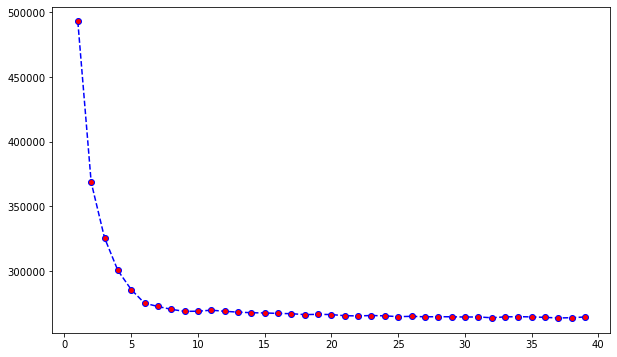

In [11]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, linestyle='--', marker='o', markerfacecolor='red', color='blue')

In [12]:
print("Best K:", error_rate.index(min(error_rate)))
print("Best RMSE:", min(error_rate))

Best K: 36
Best RMSE: 263821.32380546525


<a name="initial-regression-model-run"></a>
## Running Each Regression Model to get summary of all RMSEs
<h3> Models tested </h3>
<ul>
    <li> KNN </li>
    <li> Linear Regression </li>
    <li> Ridge </li>
    <li> Elasticnet </li>
    <li> Lasso </li>
    <li> Bayesian Ridge </li>
    <li> Support Vector Regression </li>
    <li> Random Forest Regression </li>
    <li> Decision Tree Regression </li>
</ul>

In [13]:
models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=36, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}

atm_names = new_data['ATM Name'].unique()

<a name="compute-rmse"></a>
<h3> Compute RMSE function </h3>
<p> It loops over all models given, fits train data and predicts on test data </p>

In [49]:
def compute_rmse_model_list(models, X_train, y_train, X_test, y_test):
    print("RMSEs for each model")
    testing_scores = dict()
    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train)
        model_predictions = model.predict(X_test)
        model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
        model_testing_score = model.score(X_test, y_test)
        model_training_score = model.score(X_train, y_train)
        print("For", model_name)
        print("\tTesting RMSE = {}".format(model_rmse))
        print("\tTraining Score =", model_training_score)
        print("\tTesting Score =", model_testing_score)
        
        # Storing the results in a dictionary, so they can be easily compared later
        testing_scores[model_name] = dict()
        testing_scores[model_name]['Training Score'] = model_training_score
        testing_scores[model_name]['Testing Score'] = model_testing_score
        testing_scores[model_name]['RMSE'] = model_rmse
    
    # return testing_scores

In [15]:
X = numeric_data.drop('Total amount Withdrawn', axis=1)
y = numeric_data['Total amount Withdrawn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 263821.32380546525
	Training Score = 0.376755664209415
	Testing Score = 0.34976990282315645
For Vanilla Linear Regression
	Testing RMSE = 251419.8192235889
	Training Score = 0.4013361571445507
	Testing Score = 0.4094641102628562
For Ridge Linear Regression
	Testing RMSE = 251395.20976856566
	Training Score = 0.401303262994798
	Testing Score = 0.40957971018028033
For Elasticnet Linear Regression
	Testing RMSE = 309411.6362690149
	Training Score = 0.10900893738529349
	Testing Score = 0.10562312336992907
For Lasso Linear Regression
	Testing RMSE = 251416.0051469024
	Training Score = 0.40133597818305683
	Testing Score = 0.40948202716449345
For Bayesian Ridge Linear Regression
	Testing RMSE = 251414.41701770766
	Training Score = 0.4009356351971536
	Testing Score = 0.4094894874363259
For Support Vector Regression
	Testing RMSE = 330060.3547257065
	Training Score = -0.02381723071492714
	Testing Score = -0.017733339289077277
For Ran

<h3> After observing the testing and training scores, its clear that Random Forest Performed the Best and Decision Tree overfits, other than that everything is not ideal but atleast no overfitting </h3>

<a name="2017-test-data"></a>
## Using only 2017 data as test data and everything else as training data

In [16]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data['Year_2017'] == 1]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1155


In [17]:
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 349507.030798516
	Training Score = 0.38667187416152216
	Testing Score = -0.07024480833352564
For Vanilla Linear Regression
	Testing RMSE = 351236.18526535534
	Training Score = 0.4535210215154458
	Testing Score = -0.080860883614569
For Ridge Linear Regression
	Testing RMSE = 350822.0331627114
	Training Score = 0.453491696908386
	Testing Score = -0.0783134416727651
For Elasticnet Linear Regression
	Testing RMSE = 341559.4825601102
	Training Score = 0.11927880563347205
	Testing Score = -0.02212495241294432
For Lasso Linear Regression
	Testing RMSE = 351203.8417642888
	Training Score = 0.4535207159268131
	Testing Score = -0.08066183114206793
For Bayesian Ridge Linear Regression
	Testing RMSE = 350009.66670241096
	Training Score = 0.45328800801809777
	Testing Score = -0.0733253202260633
For Support Vector Regression
	Testing RMSE = 339521.12487241626
	Training Score = -0.025157973486803265
	Testing Score = -0.009961686343598508
F

<h3> Random Forest and Decision Tree overfit here but everything else performs quite poorly for both training and testing</h3>

<a name="outlier-analysis"></a>
## Outlier Analysis

<h3> Finding out the total amount withdrawn per month per year </h3>

In [18]:
# Takes like 15-20 seconds to compute
total_amt_per_mon_per_yr = {}
for year in new_data['Year'].unique():
    for month in new_data['Month'].unique():
        total_amt_per_mon_per_yr[(year, month)] = sum(new_data[new_data.apply(lambda x: x['Year'] == year
                            and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

<p> total_amt_per_mon_per_yr is basically a dictionary whose key is a tuple (year, month) and its value contains the total amount withdrawn in the month of the year specified in the key, so (2011, 1): 65360200, means that 65360200 was withdrawn in total in the month of January 2011 </p>

In [19]:
from pprint import pprint

# Uncomment this if you want to see what the dictionary is like but its a big list and takes up space so its commented
# pprint(total_amt_per_mon_per_yr)

In [20]:
total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
print("Total Amount Withdrawn:", total_amount_withdrawn)
print("Average Amount Withdrawn:", avg_amount_withdrawn)

Total Amount Withdrawn: 6053002800
Average Amount Withdrawn: 72059557.14285715


<a name="outlier-months"></a>
<h3> Figuring out Outlier Months </h3>
<p> So the logic is that you take the total amount withdrawn in each month (of each year ofc) and then check its difference from the average amount withdrawn per month per year, and there's a tolerance percent variable (currently 0.7), so if the difference (positive or negative) is greater than 70% of the avg_amount_withdrawn, then that month of that year is an outlier </p>

In [21]:
tolerance_percent = 0.7

for key in total_amt_per_mon_per_yr:
    amount = total_amt_per_mon_per_yr[key]
    if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
        print(key)

(2016, 11)
(2016, 12)
(2017, 10)
(2017, 11)
(2017, 12)


<h3> Removing outlier months from 2017 in test set </h3>

In [22]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data.apply(lambda x: x['Year_2017'] == 1
                            and x['Month_10'] != 1 and x['Month_11'] != 1 and x['Month_12'] != 1, axis=1)]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1053


<a name="outlier-months-compute-rmse"></a>
<h3> Running Compute RMSE Model List after removing Outlier Months from test data </h3>

In [23]:
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 351022.25503262907
	Training Score = 0.38667187416152216
	Testing Score = -0.06821091445126548
For Vanilla Linear Regression
	Testing RMSE = 351707.41076749505
	Training Score = 0.4535210215154458
	Testing Score = -0.0723850379299813
For Ridge Linear Regression
	Testing RMSE = 351324.7551906196
	Training Score = 0.453491696908386
	Testing Score = -0.07005281022397458
For Elasticnet Linear Regression
	Testing RMSE = 343412.7436405998
	Training Score = 0.11927880563347205
	Testing Score = -0.022399249112364794
For Lasso Linear Regression
	Testing RMSE = 351678.3929187876
	Training Score = 0.4535207159268131
	Testing Score = -0.0722080895796422
For Bayesian Ridge Linear Regression
	Testing RMSE = 350563.3036768458
	Training Score = 0.45328800801809777
	Testing Score = -0.06541943133494232
For Support Vector Regression
	Testing RMSE = 341482.3478579618
	Training Score = -0.025157973486803265
	Testing Score = -0.01093730936595171

<h3> A slight improvement but pretty insignificant</h3>

<a name="outlier-days"></a>
<h3> Figuring out Outlier Days with 75% difference from the average amount withdrawn per day as the tolerance</h3>

In [24]:
avg_amount_withdrawn_per_day = sum(new_data['Total amount Withdrawn']) / len(new_data['Total amount Withdrawn'])
tolerance_percent = 0.75

outlier_day_data = new_data[new_data.apply(lambda x: abs(avg_amount_withdrawn_per_day - x['Total amount Withdrawn']) > 
                            avg_amount_withdrawn_per_day * tolerance_percent, axis=1)]

In [25]:
outlier_day_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
5,Big Street ATM,52800,SUNDAY,NH,H,HHW,2,1,2011
10,Big Street ATM,88100,MONDAY,NH,W,WWW,3,1,2011
13,KK Nagar ATM,1333100,MONDAY,NH,W,WWW,3,1,2011
...,...,...,...,...,...,...,...,...,...
11558,Christ College ATM,1253100,SATURDAY,NH,H,WHH,9,23,2017
11567,KK Nagar ATM,1175200,MONDAY,NH,W,HWW,9,25,2017
11577,KK Nagar ATM,997800,WEDNESDAY,NH,W,WWW,9,27,2017
11582,KK Nagar ATM,1154900,THURSDAY,NH,W,WWH,9,28,2017


In [26]:
# Kinda useless, prints a really big list that's all
# for idx, row in outlier_day_data.iterrows():
#     print("{}, {}, {}".format(row['Year'], row['Month'], row['Day']))

<a name="outlier-day-per-atm"></a>
<h3> Finding out Outlier Day Data Per ATM Per Month </h3>

In [27]:
for atm in outlier_day_data['ATM Name'].unique():
    print("For ATM:", atm)
    print(outlier_day_data[outlier_day_data['ATM Name'] == atm]['Month'].value_counts(), "\n")

For ATM: Big Street ATM
11    42
3     42
4     40
1     40
7     38
8     34
2     34
6     31
5     27
12    25
10    22
9     20
Name: Month, dtype: int64 

For ATM: KK Nagar ATM
1     95
5     85
8     84
10    83
7     83
11    82
3     82
6     78
4     77
2     76
9     74
12    69
Name: Month, dtype: int64 

For ATM: Christ College ATM
5     38
1     35
4     34
3     33
10    29
8     26
7     26
6     26
2     24
11    16
9     15
12    10
Name: Month, dtype: int64 

For ATM: Airport ATM
1     23
7     22
5     19
3     18
6     17
2     17
11    16
10    16
4     15
9     14
8     14
12    11
Name: Month, dtype: int64 

For ATM: Mount Road ATM
6     40
4     39
5     36
3     36
1     34
8     26
7     25
11    24
10    22
2     20
9     14
12    11
Name: Month, dtype: int64 



<h3> Basically KK Nagar ATM has vastly large number of outlier days as compared to the others and Airport ATM is the best in this regard </h3>

<h3> Finding out Outlier Data Per ATM Per Year </h3>

In [28]:
for atm in outlier_day_data['ATM Name'].unique():
    print("For ATM:", atm)
    print(outlier_day_data[outlier_day_data['ATM Name'] == atm]['Year'].value_counts(), "\n")

For ATM: Big Street ATM
2011    243
2012     78
2016     30
2017     24
2014      8
2015      7
2013      5
Name: Year, dtype: int64 

For ATM: KK Nagar ATM
2013    260
2014    258
2012    157
2016     86
2017     85
2015     69
2011     53
Name: Year, dtype: int64 

For ATM: Christ College ATM
2017    92
2014    75
2016    69
2015    34
2013    19
2012    12
2011    11
Name: Year, dtype: int64 

For ATM: Airport ATM
2016    68
2017    54
2015    35
2014    17
2013    14
2012    11
2011     3
Name: Year, dtype: int64 

For ATM: Mount Road ATM
2016    106
2015     54
2014     54
2017     50
2012     30
2013     24
2011      9
Name: Year, dtype: int64 



<a name="model-training-per-atm"></a>
## Training all models for each ATM separately

In [14]:
def model_training_per_atm(atm_name):
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]
    
    ''' Finding Outlier Months for each bank separately
    print("\nOutlier Months for bank {} are as follows,".format(bank_name))
    total_amt_per_mon_per_yr = {}
    for year in curr_bank_data['Year'].unique():
       for month in curr_bank_data['Month'].unique():
           total_amt_per_mon_per_yr[(year, month)] = sum(curr_bank_data[curr_bank_data.apply(lambda x: x['Year'] == year
                               and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

    total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
    avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
    # print("Total Amount Withdrawn:", total_amount_withdrawn)
    # print("Average Amount Withdrawn:", avg_amount_withdrawn)

    tolerance_percent = 0.7

    for key in total_amt_per_mon_per_yr:
        amount = total_amt_per_mon_per_yr[key]
        if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
            print(key)
    '''
    
    # This takes 2016 data as test data and ignores 2017 data completely
    # train_data = numeric_curr_bank_data[numeric_curr_bank_data.apply(lambda x: x['Year_2017'] == 0 and 
    #                                                                 x['Year_2016'] == 0, axis=1)]
    # test_data = numeric_curr_bank_data[numeric_curr_bank_data['Year_2016'] == 1]
    # Conclusions: For some reason, Airport ATM accuracy increases slightly somehow but everything else gets destroyed
    
    
    print("\nFor ATM:", atm_name)
    print("Number of training rows:",len(train_data))
    print("Number of testing rows:", len(test_data))
    print()

    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    testing_dict_curr_atm = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)
    return testing_dict_curr_atm

In [30]:
for atm_name in new_data['ATM Name'].unique():
    model_training_per_atm(atm_name)
    
# Note: Bayesian Ridge Linear Regression does not converge for the Mount Road and KK Nagar models and increasing n_iter
# to even 5000 (default is 350) didn't change that at all


For ATM: Big Street ATM
Number of training rows: 2117
Number of testing rows: 237

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 181461.59767223545
	Training Score = 0.28999562819250424
	Testing Score = -0.36556725432459025
For Vanilla Linear Regression
	Testing RMSE = 276512.2844681913
	Training Score = 0.5444464813526175
	Testing Score = -2.1708266083172028
For Ridge Linear Regression
	Testing RMSE = 273587.69620255945
	Training Score = 0.5442115519020725
	Testing Score = -2.104107536431348
For Elasticnet Linear Regression
	Testing RMSE = 160736.02690753856
	Training Score = 0.13017936078590775
	Testing Score = -0.07144551642773656
For Lasso Linear Regression
	Testing RMSE = 276469.1320024553
	Training Score = 0.5444461398934355
	Testing Score = -2.169837008089656
For Bayesian Ridge Linear Regression
	Testing RMSE = 270701.1207086409
	Training Score = 0.5436357614309526
	Testing Score = -2.038951303826138
For Support Vector Regression
	Testing RMSE = 158495.819471549

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318209236896.22656, tolerance: 12393046096.022762
  model = cd_fast.enet_coordinate_descent(


 Lasso Linear Regression
	Testing RMSE = 322203.5496961272
	Training Score = 0.5181017969667947
	Testing Score = -2.0088051198912362
For Bayesian Ridge Linear Regression
	Testing RMSE = 324014.4789707869
	Training Score = 0.5135989086530637
	Testing Score = -2.0427218501556643
For Support Vector Regression
	Testing RMSE = 322190.0963087881
	Training Score = -0.00016256288294114185
	Testing Score = -2.0085538639651888
For Random Forest Regression
	Testing RMSE = 331526.16585152486
	Training Score = 0.9213510863896807
	Testing Score = -2.185437144767429
For Decision Tree Regression
	Testing RMSE = 353282.6087101108
	Training Score = 1.0
	Testing Score = -2.617245085793729

For ATM: Airport ATM
Number of training rows: 2058
Number of testing rows: 195

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 280998.75391993637
	Training Score = 0.21011877894017894
	Testing Score = -0.320081646974691
For Vanilla Linear Regression
	Testing RMSE = 270419.38396096433
	Training Score = 0.

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4886918595366.969, tolerance: 40041415972.54263
  model = cd_fast.enet_coordinate_descent(


 Bayesian Ridge Linear Regression
	Testing RMSE = 449447.70286618423
	Training Score = 0.5109456907699065
	Testing Score = -0.46117843124706037
For Support Vector Regression
	Testing RMSE = 476342.10707451584
	Training Score = -0.010162086368770362
	Testing Score = -0.641280726160238
For Random Forest Regression
	Testing RMSE = 446464.35931254225
	Training Score = 0.9296492296426693
	Testing Score = -0.4418447935931553
For Decision Tree Regression
	Testing RMSE = 486396.66790428065
	Training Score = 1.0
	Testing Score = -0.7112998210196062

For ATM: Christ College ATM
Number of training rows: 2115
Number of testing rows: 240

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 454068.21878890437
	Training Score = 0.2887955781878394
	Testing Score = -0.48406666444966473
For Vanilla Linear Regression
	Testing RMSE = 563369.5987146889
	Training Score = 0.4884805976915243
	Testing Score = -1.2845360365183236
For Ridge Linear Regression
	Testing RMSE = 559635.1538683609
	Training 

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303677188912.1094, tolerance: 13354579722.531445
  model = cd_fast.enet_coordinate_descent(


For Support Vector Regression
	Testing RMSE = 464427.1776615809
	Training Score = -0.01517727140145797
	Testing Score = -0.552553057061139
For Random Forest Regression
	Testing RMSE = 570794.3502511033
	Training Score = 0.9151731091368434
	Testing Score = -1.3451494806430775
For Decision Tree Regression
	Testing RMSE = 574500.6400852251
	Training Score = 1.0
	Testing Score = -1.3757034710467742


<h3> Performance has drastically improved as a result of training on individual ATMs instead of all of them </h3>

<h3> Upto this point, removing outlier months from test set has had no effect, be it for the model with all ATMs or for individual ATMs, infact it made the RMSE worse at times, so the outlier month part is ignored for now </h3>

<a name="train-one-model-but-diff-test"></a>
## Training Model on All ATMs but using Test Data from individual ATMs

In [31]:
def all_atm_model_training_with_different_test_atms(data):
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    atm_names = data['ATM Name'].unique()
    
    numeric_data = convert_categorical_to_numerical(data, categorical_features_list)
    
    train_data = numeric_data[numeric_data['Year_2017'] == 0]
    test_data = numeric_data[numeric_data['Year_2017'] == 1]
    
    for atm_name in atm_names:
        print("\nFor ATM:", atm_name)
        
        # Dropping the first ATM Name_atm_names[0] column because the one-hot function doesn't do drop_first
        # for ATM Name column
        X_train = train_data.drop(['Total amount Withdrawn', 'ATM Name_' + atm_names[0]], axis=1)
        y_train = train_data['Total amount Withdrawn']
        
        curr_atm_test_data = test_data[test_data['ATM Name_' + atm_name] == 1]
        X_test = curr_atm_test_data.drop(['Total amount Withdrawn', 'ATM Name_' + atm_names[0]], axis=1)
        y_test = curr_atm_test_data['Total amount Withdrawn']

        compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

In [32]:
all_atm_model_training_with_different_test_atms(new_data)


For ATM: Big Street ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 160761.22195743438
	Training Score = 0.4327735808352957
	Testing Score = -0.07178143662536951
For Vanilla Linear Regression
	Testing RMSE = 220189.09903158937
	Training Score = 0.4535210215154458
	Testing Score = -1.010644370788854
For Ridge Linear Regression
	Testing RMSE = 219278.1361879842
	Training Score = 0.4534921286886008
	Testing Score = -0.9940419736478675
For Elasticnet Linear Regression
	Testing RMSE = 230626.41352311775
	Training Score = 0.146904990423854
	Testing Score = -1.2057776103883073
For Lasso Linear Regression
	Testing RMSE = 220135.20854777785
	Training Score = 0.4535207159235627
	Testing Score = -1.009660295385542
For Bayesian Ridge Linear Regression
	Testing RMSE = 216769.0031492237
	Training Score = 0.4532224416363815
	Testing Score = -0.9486686321193216
For Support Vector Regression
	Testing RMSE = 206796.59945379852
	Training Score = -0.02521686557734082
	Testing Score = -0

<h3> In some ways, the bad ATMs are performing bad but some models are performing quite well on Mount Road ATM which didn't happen with the individual model, so I guess KK and Christ College ATM data were lowering the RMSE values for the overall model </h3>

<a name="no-kk"></a>
<h3> Doing the same as above but just using data from Big Street, Mount Road and Airport ATMs </h3>

In [33]:
good_data = new_data[new_data.apply(lambda x: x['ATM Name'] != 'KK Nagar ATM' 
                                    and x['ATM Name'] != 'Christ College ATM', axis=1)]

all_atm_model_training_with_different_test_atms(good_data)


For ATM: Big Street ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 158618.10337009552
	Training Score = 0.3840104394960905
	Testing Score = -0.043395930938965765
For Vanilla Linear Regression
	Testing RMSE = 188278.79850039512
	Training Score = 0.3888530973235256
	Testing Score = -0.4700986198565593
For Ridge Linear Regression
	Testing RMSE = 187658.3412392558
	Training Score = 0.38878449463634546
	Testing Score = -0.4604254071488416
For Elasticnet Linear Regression
	Testing RMSE = 167807.48386731514
	Training Score = 0.13052242796752922
	Testing Score = -0.16779412109203484


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42250940223.5625, tolerance: 31405633558.079407
  model = cd_fast.enet_coordinate_descent(


For Lasso Linear Regression
	Testing RMSE = 188247.22492758566
	Training Score = 0.3888525917818654
	Testing Score = -0.46960560232858234
For Bayesian Ridge Linear Regression
	Testing RMSE = 185031.07441716632
	Training Score = 0.3878119473737709
	Testing Score = -0.4198189711009328
For Support Vector Regression
	Testing RMSE = 174880.2829468054
	Training Score = -0.0013433259042736623
	Testing Score = -0.2683097411069155
For Random Forest Regression
	Testing RMSE = 274207.70804347517
	Training Score = 0.9290848436307648
	Testing Score = -2.1181927034642993
For Decision Tree Regression
	Testing RMSE = 274915.451751651
	Training Score = 1.0
	Testing Score = -2.134309896650307

For ATM: Mount Road ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 294469.2194498337
	Training Score = 0.3840104394960905
	Testing Score = -1.513120011264927
For Vanilla Linear Regression
	Testing RMSE = 262493.3873361208
	Training Score = 0.3888530973235256
	Testing Score = -0.9969636172379583


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42250940223.5625, tolerance: 31405633558.079407
  model = cd_fast.enet_coordinate_descent(


For Lasso Linear Regression
	Testing RMSE = 262515.15381622716
	Training Score = 0.3888525917818654
	Testing Score = -0.9972948154557034
For Bayesian Ridge Linear Regression
	Testing RMSE = 264676.80225273105
	Training Score = 0.3878119473737709
	Testing Score = -1.0303231942122686
For Support Vector Regression
	Testing RMSE = 237358.8875030304
	Training Score = -0.0013433259042736623
	Testing Score = -0.6328429429423257
For Random Forest Regression
	Testing RMSE = 329998.07822277944
	Training Score = 0.9295525356286236
	Testing Score = -2.1561398552413413
For Decision Tree Regression
	Testing RMSE = 355214.27893237455
	Training Score = 1.0
	Testing Score = -2.6569098018571227

For ATM: Airport ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 265539.25392855983
	Training Score = 0.3840104394960905
	Testing Score = -0.1788253497447605
For Vanilla Linear Regression
	Testing RMSE = 247679.74538280914
	Training Score = 0.3888530973235256
	Testing Score = -0.025588140341515

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42250940223.5625, tolerance: 31405633558.079407
  model = cd_fast.enet_coordinate_descent(


For Lasso Linear Regression
	Testing RMSE = 247683.33469720022
	Training Score = 0.3888525917818654
	Testing Score = -0.025617865702699305
For Bayesian Ridge Linear Regression
	Testing RMSE = 247814.57944030146
	Training Score = 0.3878119473737709
	Testing Score = -0.026705081496683825
For Support Vector Regression
	Testing RMSE = 262533.8514480243
	Training Score = -0.0013433259042736623
	Testing Score = -0.15229220690026346
For Random Forest Regression
	Testing RMSE = 278609.9310957977
	Training Score = 0.9291228524321696
	Testing Score = -0.2977325288493433
For Decision Tree Regression
	Testing RMSE = 286457.2980214391
	Training Score = 1.0
	Testing Score = -0.3718662988052206


<h3> Conclusions: </h3>
<p> For Big Street ATM: Before, Best Performance = 160761 by KNN with k = 37. Now, it is 158618 also by KNN with k = 37, so an improvement</p>
<p> For Mount Road ATM: Before, Best Performance = 236570 by Vanilla LR with k = 37. Now, it is 237358 by SVR, so performance worsened somehow </p>
<p> For Airport ATM: Before, Best Performance = 251569 by Bayesian Ridge. Now, it is 247664 by Ridge, so performance increased </p>
<p> In summary, we got an improvement of 2k for Big Street, a decrement of 1k for Mount Road and an increment of 4k for Airport. So its definitely helping improve our cause but man that's still very marginal improvement </p>



<a name="hyperparameter"></a>
## Hyperparameter Tuning (done for individual ATMs) with Train-Test Split

<p> Note that the function below this cell takes the atm_name and the random search or grid search object and does all the tasks of converting to numeric data, train test split using 2017 data or regular train_test_split and then does Cross Validation and then computes the RMSE on the best estimator found after hyperparameter search </p>

In [12]:
categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']

In [48]:
# Works for both RandomizedSearchCV() object and GridSearchCV() object
def model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      param_cv_obj, test_split=False, tree_model='Invalid'):
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    if test_split == True:
        print("Using Train-Test Split")
        X = numeric_curr_atm_data.drop('Total amount Withdrawn', axis=1)
        y = numeric_curr_atm_data['Total amount Withdrawn']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    else:
        print("Using 2017 Data as Test Data")
        train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
        test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]

        X_train = train_data.drop('Total amount Withdrawn', axis=1)
        y_train = train_data['Total amount Withdrawn']

        X_test = test_data.drop('Total amount Withdrawn', axis=1)
        y_test = test_data['Total amount Withdrawn']
    
    param_cv_obj.fit(X_train, y_train)
    print("Best Parameters:\n", param_cv_obj.best_params_)
    print("\nBest CV RMSE:", -param_cv_obj.best_score_)
    if 'mean_train_score' in param_cv_obj.cv_results_:
        # nanmean() is used here instead of mean() because for DecisionTree the mean_train_score actually contains nan
        # for some reason, so nanmean() ignores it while computing mean
        print("Best Training RMSE:", -np.nanmean(param_cv_obj.cv_results_['mean_train_score']))
    
    best_model = param_cv_obj.best_estimator_
    model_predictions = best_model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    
    print("Test RMSE:", model_rmse)
    
    column_names = X_train.columns
    
    if tree_model == False:
        # p_val_array[1:] because 0-th index is reserved for intercept p-val which is not required for us
        p_val_array = coef_pval(best_model, X_train, y_train)
        [print("{} : {}".format(x, y)) for x, y in zip(column_names, p_val_array[1:]) if y < 0.05]
        
    elif tree_model == True:
        r = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=0)
        for i in r.importances_mean.argsort()[::-1]:
            if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                print(f"{column_names[i]:<8}: "
                      f"{r.importances_mean[i]:.3f}"
                      f" +/- {r.importances_std[i]:.3f}")
        
    print("------------------------------------------------------------------------\n")    

<a name="hyperparameter-svr"></a>
<h3> SVR Hyperparameter Tuning </h3>

In [35]:
svr_param_grid = {'C': list(np.logspace(-3, 5, num=25)),
                         'epsilon': list(np.logspace(-3, 3, num=25))}

random_cv_svr = RandomizedSearchCV(SVR(), svr_param_grid, n_iter=50, cv=10, verbose=2, 
                                   n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_cv_svr = GridSearchCV(SVR(), svr_param_grid, verbose=2, cv=10, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [36]:
for atm_name in atm_names:
    print("\nPerforming Random Search with SVR on", atm_name, "\n")
    # model_training_hyperparam_per_atm(atm_name, grid_cv_svr)
    # model_training_hyperparam_per_atm(atm_name, random_cv_svr)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, random_cv_svr, test_split=True)


Performing Random Search with SVR on Big Street ATM 

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Best Parameters:
 {'epsilon': 177.82794100389228, 'C': 100000.0}

Best CV RMSE: 115436.08251199863
Best Training RMSE: 149058.4208142128
Test RMSE: 113207.55750350958

Performing Random Search with SVR on Mount Road ATM 

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Best Parameters:
 {'epsilon': 3.1622776601683795, 'C': 100000.0}

Best CV RMSE: 177915.88727891992
Best Training RMSE: 239275.9864220719
Test RMSE: 178854.37727720288

Performing Random Search with SVR on Airport ATM 

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Best Parameters:
 {'epsilon': 1000.0, 'C': 46415.888336127726}

Best CV RMSE: 174459.49102225475
Best Training RMSE: 194473.7388945959
Test RMSE: 173268.41091633053

Performing Random Search with SVR on KK Nagar ATM 

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best Parameters:
 {'epsilon': 0.1778279410038923, 'C': 100000.0}

Best CV RMSE: 312430.66224168206
Best Training RMSE: 419045.3798527236
Test RMSE: 323852.884543254

Performing Random Search with SVR on Christ College ATM 

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best Parameters:
 {'epsilon': 0.0031622776601683794, 'C': 100000.0}

Best CV RMSE: 213569.11955877114
Best Training RMSE: 271251.5549474188
Test RMSE: 210804.00454386178


<h3> For some reason the Training RMSE is higher than both CV and Test RMSEs for all ATMs </h3>


<a name="validation-curve"></a>
<h3> Plotting Validation Curve => Train Error vs Cross Validation Error (Y-Axis) wrt one numeric parameter (X-Axis) </h3>

<p> Note that the validation_curve() method returns the train_score and validation_scores. These scores are an array of dimension (n_ticks, n_cv_folds). cv=10, so n_cv_folds=10, n_ticks = number of values that the parameter being tested again takes, here that parameter is alpha and I used 50 values of alpha in the range 10^-3 to 10^3 (log-spaced) </p>

<p> Plotting these curves for Lasso and Ridge Regression basically proved that hyperparameter tuning actually works and that weird behaviour displayed before where hyperparameters kept taking the maximum value in the specified parameter range as the best value (no matter how many times the range was updated wasn't really weird </p>

In [37]:
def plot_validation_curve_each_atm(model, param_name, param_range):
    best_param_per_atm = dict()
    
    for atm_name in atm_names:
        categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']

        curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
        numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)

        train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
        test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]

        X_train = train_data.drop('Total amount Withdrawn', axis=1)
        y_train = train_data['Total amount Withdrawn']

        X_test = test_data.drop('Total amount Withdrawn', axis=1)
        y_test = test_data['Total amount Withdrawn']

        train_scores, valid_scores = validation_curve(model, X_train, y_train, param_name, 
                                                      param_range, cv=10, 
                                                      scoring='neg_root_mean_squared_error',
                                                     verbose=2, n_jobs=-1)

        # The scoring used was neg_root_mean_squared_error, so multiply each element by -1 to get its positive equivalent
        train_scores = np.array([-1 * x for x in train_scores])
        valid_scores = np.array([-1 * x for x in valid_scores])

        # Taking the mean of the 10 CV errors and converting train_scores and valid_scores to an array of size n_ticks = 50
        train_scores_mean = np.mean(train_scores, axis=1) 
        valid_scores_mean = np.mean(valid_scores, axis=1)

        # print(train_scores_mean)
        plt.figure(figsize=(12, 5))

        plt.title("Validation Curve For {}\nBest CV RMSE = {} for {} = {}".
                  format(atm_name, min(valid_scores_mean), param_name, param_range[np.argmin(valid_scores_mean)]))

        plt.xlabel(param_name)
        plt.ylabel("RMSE")
        lw = 2

        # Note semilogx is just plot function where the X-axis is scaled according to logscale
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
        plt.legend(loc="best")
        plt.show()
        
        best_param_per_atm[atm_name] = param_range[np.argmin(valid_scores_mean)]
        
    return best_param_per_atm

<a name="hyperparameter-lasso"></a>
<h3> Hyperparameter Tuning for Lasso </h3>
<p> Alpha is the only tunable parameter here </p>

<h3> GridSearch with Lasso() </h3>

In [49]:
lasso_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=2, n_jobs=-1, 
                             scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)
# random_cv_lasso = RandomizedSearchCV(Lasso(max_iter=2000), lasso_param_grid, n_iter=25, verbose=2, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=10)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      grid_cv_lasso, test_split=True, tree_model=False)
    # model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, grid_cv_lasso)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:  1.3min remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Best Parameters:
 {'alpha': 79.06043210907701}

Best CV RMSE: 115168.57557097558
Best Training RMSE: 111594.7894698708
Test RMSE: 110094.77526150743
Weekday_MONDAY : 0.029683930625768573
Weekday_THURSDAY : 0.00599333044293715
Weekday_TUESDAY : 0.002392573696966549
Weekday_WEDNESDAY : 0.0014389817055817655
Festival Religion_N : 0.02213304229397428
Month_7 : 0.04731337340759878
Month_9 : 0.04320011351352626
Month_10 : 0.011322005102376576
Month_12 : 0.037423129043171466
Day_6 : 0.00041814471478462956
Day_8 : 0.009987041364592164
Day_9 : 9.215740790935456e-06
Day_10 : 0.02244931303613784
Day_11 : 0.0008106010385153795
Day_12 : 3.3856745567106827e-06
Day_17 : 0.024804045780659312
Day_23 : 0.0026162257472921446
Day_24 : 0.002459432362825309
Day_25 : 0.037919499378254784
Day_27 : 0.03507618144967162
Day_31 : 0.020998406581065554
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2016 : 0.0
Year_2017 : 0.0
---------------------------------------------------------------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Best Parameters:
 {'alpha': 59.636233165946365}

Best CV RMSE: 178230.89375495748
Best Training RMSE: 171430.5524360542
Test RMSE: 180578.96756323558
Weekday_SATURDAY : 1.3905631535138241e-08
Weekday_THURSDAY : 0.013397435630235988
Weekday_WEDNESDAY : 0.006933739693454566
Working Day_W : 0.04883960812772581
Month_2 : 0.007864181875821386
Month_3 : 0.005394203619536242
Month_4 : 0.0166155401172694
Month_5 : 2.2873093907804787e-07
Month_6 : 0.003478167634181739
Month_7 : 0.0036072624899077255
Month_8 : 0.009980633019166518
Month_10 : 0.0016042153953250704
Month_11 : 0.005107589462370221
Day_10 : 0.003146347572537511
Day_13 : 8.813234830817862e-08
Day_14 : 4.944747966639795e-08
Day_15 : 2.722710945590734e-12
Day_16 : 4.374278717023117e-12
Day_17 : 1.906675928253776e-09
Day_18 : 1.0719514165202781e-10
Day_19 : 4.7052617357934423e-07
Day_20 : 1.88457323080371e-08
Day_21 : 6.73456914679349e-08
Day_22 : 5.706990435783155e-12
Day_23 : 5.760725230175012e-12
Day_24 : 8.413492125214361e-12
Day_25

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:  1.1min remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Parameters:
 {'alpha': 244.205309454865}

Best CV RMSE: 177497.1787373141
Best Training RMSE: 170390.9042503523
Test RMSE: 162220.62598650812
Weekday_SATURDAY : 0.00016048376518984497
Holiday Sequence_HHW : 0.019171571141196386
Month_3 : 0.03903777094218652
Month_12 : 0.004248461602344822
Day_3 : 0.036349385091613895
Day_4 : 0.03323392481804799
Day_6 : 0.0011427773913683659
Day_8 : 1.1992676409722236e-06
Day_11 : 0.009743733014536016
Day_25 : 0.016318589031079522
Day_31 : 0.025963706130915698
Year_2012 : 6.391998041976876e-12
Year_2013 : 2.220446049250313e-16
Year_2014 : 1.421366538689739e-06
Year_2016 : 0.0
Year_2017 : 1.311839525897085e-12
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Parameters:
 {'alpha': 754.3120063354608}

Best CV RMSE: 314191.72812336654
Best Training RMSE: 302351.31385273125
Test RMSE: 351035.2366434492
Weekday_SATURDAY : 0.02100223000036472
Weekday_SUNDAY : 0.004882702327106747
Weekday_WEDNESDAY : 0.014888366392040053
Month_5 : 0.03597872004320979
Month_7 : 0.02171995814251093
Month_9 : 0.03984642470745081
Month_11 : 0.0011122221610502248
Day_4 : 0.01841213980445544
Day_6 : 5.008109038584507e-09
Day_9 : 0.029459547600099167
Day_10 : 0.00012669955051647364
Day_18 : 0.03326446723749821
Day_23 : 0.009291600015463253
Day_24 : 0.0028309582240859665
Day_31 : 0.00023269757615329567
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 2.220446049250313e-16
Year_2016 : 1.7548185127225224e-12
Year_2017 : 0.0
------------------------------------------------------------------------


For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:   54.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.1s finished


Best Parameters:
 {'alpha': 19.306977288832496}

Best CV RMSE: 201877.34820063427
Best Training RMSE: 195688.16435452233
Test RMSE: 223285.9678860619
Weekday_MONDAY : 0.006964633609960469
Weekday_SATURDAY : 2.7400304247748863e-13
Weekday_THURSDAY : 1.0266048752205492e-05
Weekday_TUESDAY : 0.0024892154601121597
Weekday_WEDNESDAY : 2.64581019118193e-05
Working Day_W : 8.122657504383568e-06
Holiday Sequence_HHW : 0.005869121336808503
Holiday Sequence_WHH : 0.012515078818277514
Holiday Sequence_WHW : 0.007505624547645917
Month_12 : 5.415395025210046e-05
Day_3 : 0.04938747244520081
Day_7 : 0.0017341605381060443
Day_8 : 0.018451480971285017
Day_9 : 1.8954863636677644e-05
Day_10 : 0.0003656808576861792
Day_13 : 0.014647062770526187
Day_14 : 0.000239079407340137
Day_15 : 0.030842550638222166
Day_16 : 6.625614463517948e-06
Day_17 : 0.0014099466232706526
Day_18 : 3.3271964405834353e-07
Day_19 : 0.0005290345677086972
Day_20 : 8.911279693091245e-05
Day_21 : 3.620333565779177e-05
Day_22 : 8.5048524

<h3> Cross Validation Curve for Lasso wrt Alpha </h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:   32.0s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.9s finished


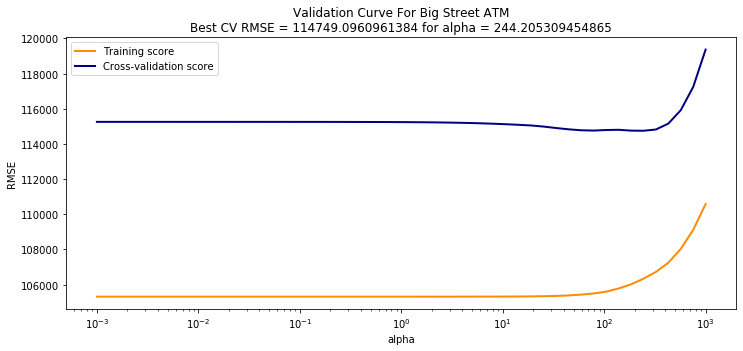

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:   36.2s remaining:   36.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


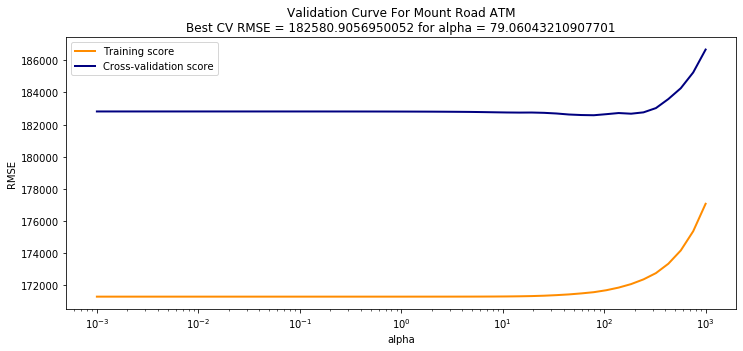

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:   29.7s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.3s finished


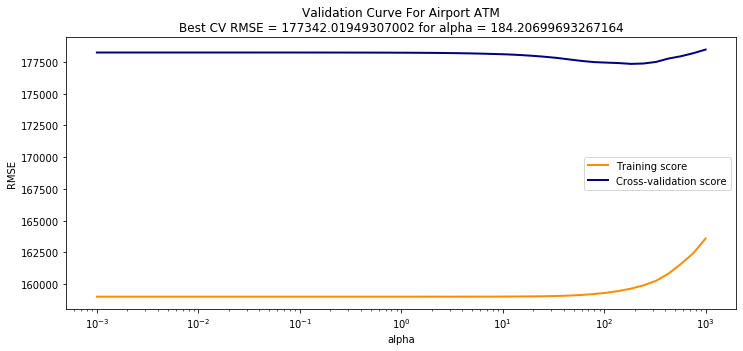

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:   43.3s remaining:   43.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


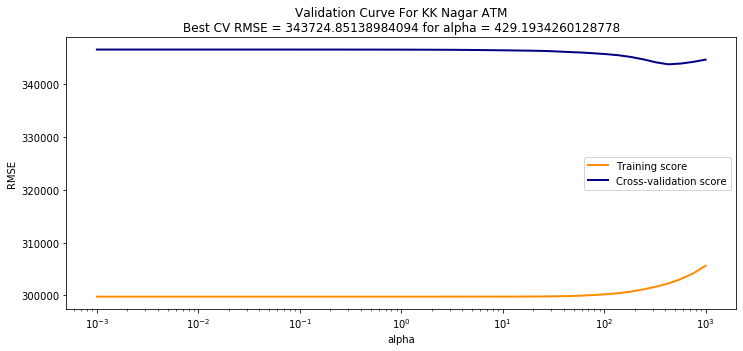

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:   37.3s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


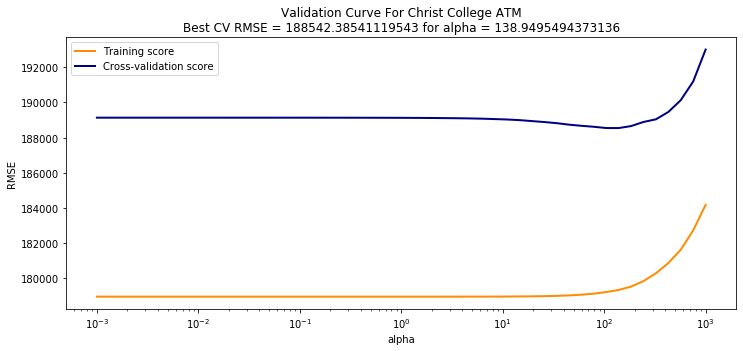

In [39]:

alphas = np.logspace(-3, 3, num=50)
best_alpha_values_lasso = plot_validation_curve_each_atm(Lasso(max_iter=5000), "alpha", alphas)


<h3>  We achieve quite good CV and Test RMSEs which outperform even SVR and they are also higher than Training RMSEs unlike SVR </h3>

<a name="hyperparameter-ridge"></a>
<h3> Hyperparameter Tuning for Ridge </h3>
<p> Alpha is again the only tunable parameter here </p>

In [50]:
ridge_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_ridge = GridSearchCV(Ridge(), ridge_param_grid, verbose=5, n_jobs=-1, scoring='neg_root_mean_squared_error'
                            ,return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      grid_cv_ridge, test_split=True, tree_model=False)
    # model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, grid_cv_ridge)
    


For Big Street ATM
Using Train-Test Split
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 2.023589647725158}

Best CV RMSE: 115474.27493629821
Best Training RMSE: 117945.85122695476
Test RMSE: 111375.79518693798
Weekday_MONDAY : 0.0037898158173899077
Weekday_SATURDAY : 0.03713128761779827
Weekday_THURSDAY : 0.0007008999280473382
Weekday_TUESDAY : 2.725724989516287e-05
Weekday_WEDNESDAY : 0.00022082560837732856
Festival Religion_N : 0.04799461960365292
Month_9 : 0.011274820346668157
Month_10 : 0.0009727506474053182
Month_12 : 0.007896285188309093
Day_8 : 0.026070968739658973
Day_9 : 0.00017872807187879758
Day_10 : 0.027699153528793152
Day_11 : 0.0013570462151435425
Day_12 : 0.0005430454817845209
Day_17 : 0.0018460377662985472
Day_18 : 0.0025073823540227025
Day_19 : 0.013940329862032197
Day_21 : 0.03316383702424597
Day_22 : 0.009455641507960744
Day_23 : 0.0005220636059992678
Day_24 : 0.0003000575807545758
Day_25 : 0.0010950760298542583
Day_26 : 0.016463520687352906
Day_27 : 0.002241103038902237
Day_28 : 0.01822577646227197
Day_31 : 0.00393318819944

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 0.15998587196060574}

Best CV RMSE: 178463.11619137603
Best Training RMSE: 179843.60970978535
Test RMSE: 182915.40342190603
Weekday_SATURDAY : 4.187783453346583e-11
Weekday_WEDNESDAY : 0.02691360508469498
Working Day_W : 0.04094302077571377
Holiday Sequence_WHW : 0.01978563074273354
Month_2 : 0.0013490122923476289
Month_3 : 0.00047354756020423494
Month_4 : 0.0002645779896264244
Month_5 : 7.88457077405269e-10
Month_6 : 0.00017018735709051214
Month_7 : 8.373784050785815e-05
Month_8 : 0.0001014835691355298
Month_9 : 0.008571667945696637
Month_10 : 0.0015845696189640268
Month_11 : 0.03168002493971844
Day_5 : 0.004317227655251887
Day_10 : 0.008065421735887535
Day_13 : 1.109623504191859e-11
Day_14 : 1.907320594796147e-07
Day_15 : 1.3367085216486885e-13
Day_16 : 2.220446049250313e-16
Day_17 : 8.880229884766777e-12
Day_18 : 1.2743139876647547e-12
Day_19 : 1.5622925175762248e-10
Day_20 : 3.2006486350155683e-10
Day_21 : 3.1596947280831955e-13
Day_22 : 6.94999613415348

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.5s finished


Best Parameters:
 {'alpha': 4.714866363457395}

Best CV RMSE: 171369.0941336552
Best Training RMSE: 169182.60377974212
Test RMSE: 180786.23298270753
Weekday_SATURDAY : 0.000313788170467566
Weekday_WEDNESDAY : 0.007131192231025318
Holiday Sequence_WHH : 0.0016319614997397647
Month_3 : 0.03125755327979074
Day_4 : 0.026687756123723316
Day_6 : 0.010791962523886589
Day_8 : 2.167589034063333e-05
Day_15 : 0.03811530041281608
Day_16 : 0.011285087175856967
Day_17 : 0.021473543752656088
Day_19 : 0.011861723974486482
Day_22 : 0.014184418084416839
Day_23 : 0.012781560439539152
Day_24 : 0.01038561180651043
Day_25 : 0.0026299796291169297
Day_26 : 0.02824110590144646
Day_28 : 0.028570958337060803
Day_31 : 0.03067119961077225
Year_2012 : 5.728750807065808e-14
Year_2013 : 0.0
Year_2014 : 3.893173339264422e-09
Year_2016 : 0.0
Year_2017 : 2.859934511434403e-13
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 5 folds for each of 50 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    7.3s finished


Best Parameters:
 {'alpha': 3.5564803062231287}

Best CV RMSE: 321154.2146088114
Best Training RMSE: 322308.411788776
Test RMSE: 319257.46497516654
Weekday_SATURDAY : 0.02159614441387281
Weekday_SUNDAY : 0.0033755310056866605
Weekday_THURSDAY : 0.0018824918327033924
Weekday_TUESDAY : 0.03435208558358083
Weekday_WEDNESDAY : 7.494543649011476e-06
Festival Religion_H : 0.0009275393523648923
Month_7 : 0.00013519973347775327
Month_8 : 0.023863669646824626
Month_9 : 0.0002798659737952569
Month_11 : 1.1607129779989123e-05
Month_12 : 0.0006016015451730805
Day_6 : 0.0002266870997607029
Day_10 : 0.0065918653599355
Day_12 : 0.028998241289937665
Day_13 : 0.019403324433648894
Day_14 : 0.005352052210286118
Day_15 : 0.028908818862719565
Day_16 : 0.001336031274919991
Day_17 : 0.015547310391055502
Day_18 : 0.0017362220084173874
Day_19 : 0.008494003097237135
Day_20 : 0.003475882260837615
Day_21 : 0.028516123898628454
Day_22 : 0.0007791266019552268
Day_23 : 1.9160359404857275e-05
Day_24 : 3.9768206199219

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.2s finished


Best Parameters:
 {'alpha': 0.655128556859551}

Best CV RMSE: 205212.13960557565
Best Training RMSE: 206122.25076828428
Test RMSE: 218433.90164038737
Weekday_MONDAY : 0.03679780841125013
Weekday_SATURDAY : 5.433431482515516e-13
Weekday_THURSDAY : 0.03859543291825229
Working Day_W : 0.00036511010242268327
Month_12 : 0.0001780877442498774
Day_8 : 0.03221619710928558
Day_9 : 0.00011359471162730728
Day_10 : 0.002619710883620563
Day_13 : 0.04043826324764899
Day_14 : 0.0001493996501071848
Day_16 : 1.4664176060108502e-06
Day_17 : 9.327683910997919e-05
Day_18 : 1.6959231856628065e-06
Day_19 : 4.1491749461552985e-05
Day_20 : 0.0001721134867065377
Day_21 : 0.001129942013045504
Day_22 : 6.810257925349283e-05
Day_23 : 2.9435695059198963e-07
Day_24 : 8.263616457782064e-10
Day_25 : 1.2114542897068148e-05
Day_26 : 2.7569125293780417e-07
Day_27 : 0.00011791821528039925
Day_28 : 3.9659290074212095e-07
Day_29 : 1.2734481560583433e-05
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2

<h3> Relatively worse results than Lasso, also often has CV RMSEs lower than Training RMSEs </h3>

<h3> Cross Validation Curve for Ridge wrt Alpha </h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.4s finished


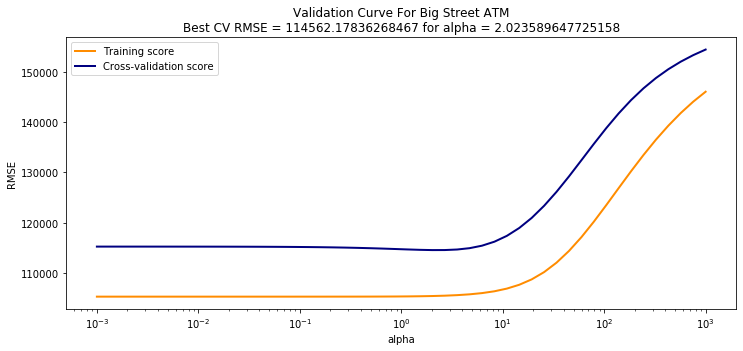

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.0s finished


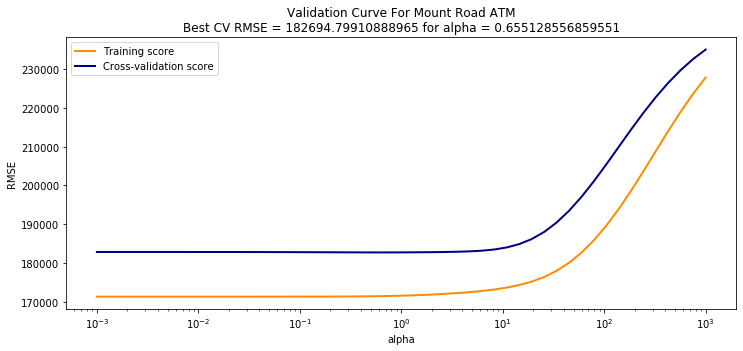

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.3s finished


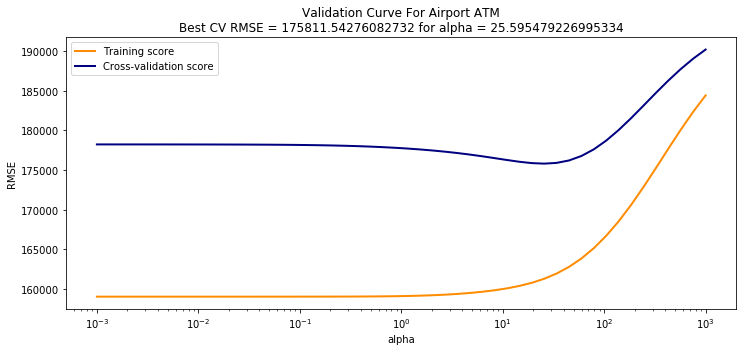

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.1s finished


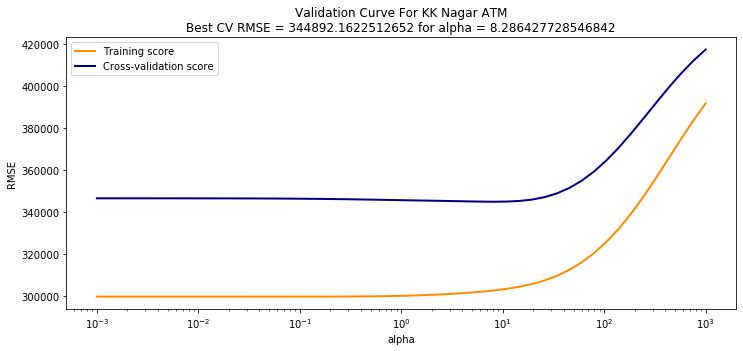

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 500 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.1s finished


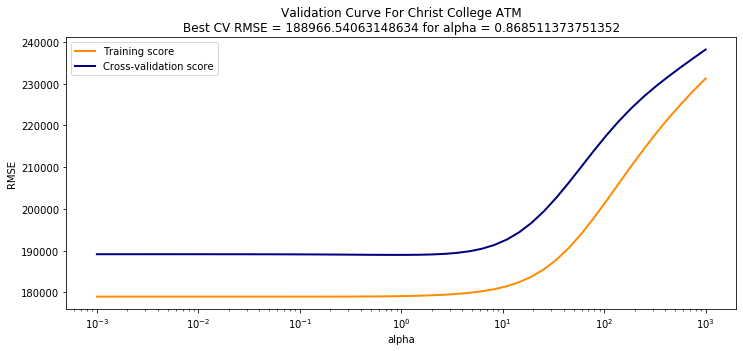

In [41]:
alphas = np.logspace(-3, 3, num=50)
best_alpha_values_ridge = plot_validation_curve_each_atm(Ridge(), "alpha", alphas)


<a name="hyperparameter-enet"></a>
<h3> Hyperparameter tuning for Elasticnet </h3>
<p> l1_ratio and alpha are the tunable parameters here </p>

In [51]:
elastic_param_grid = {'l1_ratio': [.1, .5, .7, .9, .95, .99, 1], 'alpha': np.logspace(-3, 3, num=50)}
                      
# random_cv_elastic = RandomizedSearchCV(ElasticNet(max_iter=5000), elastic_param_grid, n_iter=25, n_jobs=-1, 
#                                       scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)
grid_cv_elastic = GridSearchCV(ElasticNet(), elastic_param_grid, n_jobs=-1,
                                       scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    # model_training_hyperparam_per_atm(atm_name, random_cv_elastic)
    # model_training_hyperparam_per_atm(atm_name, grid_cv_elastic)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      grid_cv_elastic, test_split=True, tree_model=False)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 350 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2124 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.7min finished


Best Parameters:
 {'alpha': 0.012648552168552958, 'l1_ratio': 0.95}

Best CV RMSE: 115670.98014997055
Best Training RMSE: 131999.6427281511
Test RMSE: 111073.800247383
Weekday_MONDAY : 0.00131962747535197
Weekday_SATURDAY : 0.0037589115836205167
Weekday_SUNDAY : 0.009874898575635616
Weekday_THURSDAY : 7.819660704555531e-05
Weekday_TUESDAY : 3.3626268418407435e-05
Weekday_WEDNESDAY : 2.453961562776108e-05
Festival Religion_M : 0.005815046110802857
Festival Religion_N : 0.007636465918914315
Holiday Sequence_WHW : 0.03792679440181024
Month_10 : 0.01232614171212143
Month_12 : 0.007968611222168853
Day_6 : 0.0018520887859618806
Day_8 : 0.009890088965013755
Day_9 : 1.5662920711090322e-05
Day_11 : 0.03248908630670244
Day_12 : 9.591976556455606e-05
Day_17 : 0.0013523144368181583
Day_18 : 0.013672705383664718
Day_19 : 0.028701239347234786
Day_21 : 0.041054003397115846
Day_22 : 0.008664361968961032
Day_23 : 0.0015686470061939684
Day_24 : 1.9268819734907794e-05
Day_25 : 0.00013393532146777076
Day_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3493 out of 3500 | elapsed:  2.6min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.6min finished


Best Parameters:
 {'alpha': 79.06043210907701, 'l1_ratio': 1}

Best CV RMSE: 178376.39482133585
Best Training RMSE: 205873.92355915444
Test RMSE: 177892.5105252424
Weekday_MONDAY : 0.046283173943413525
Weekday_SATURDAY : 1.0298114028195471e-07
Weekday_WEDNESDAY : 0.03829961890003908
Month_2 : 0.0066845984260768265
Month_4 : 0.003837585495813256
Month_5 : 3.38207727059725e-05
Month_6 : 0.007930659563039955
Month_7 : 0.004534714853751565
Month_8 : 0.017299423326476493
Month_11 : 0.0009652787311182909
Day_10 : 0.00024016102063928457
Day_13 : 2.76037702495735e-06
Day_14 : 4.110322082695461e-07
Day_15 : 1.9116708216415645e-11
Day_16 : 8.533174167268953e-13
Day_17 : 2.067963864593736e-07
Day_18 : 3.915940904875015e-10
Day_19 : 1.0979394536647646e-05
Day_20 : 6.455192580467894e-07
Day_21 : 2.651268499853643e-06
Day_22 : 6.192157897544348e-12
Day_23 : 1.924396197949818e-10
Day_24 : 1.3989360780897186e-09
Day_25 : 9.944694623342798e-09
Day_26 : 1.3118430786107638e-09
Day_27 : 5.933948887815177e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2556 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3493 out of 3500 | elapsed:  2.6min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.6min finished


Best Parameters:
 {'alpha': 0.0517947467923121, 'l1_ratio': 0.9}

Best CV RMSE: 174993.23136477865
Best Training RMSE: 182178.307582174
Test RMSE: 172538.80934800787
Weekday_SATURDAY : 0.002492860418785714
Holiday Sequence_WHH : 0.03408496449149978
Month_3 : 0.0007792243666535636
Month_5 : 0.023883088878609016
Month_8 : 0.013101274513432015
Day_3 : 0.04967587395264883
Day_6 : 0.013524857060715822
Day_7 : 0.01040243243702843
Day_8 : 0.000307509459548605
Day_23 : 0.04330208512089251
Day_24 : 0.013389053563512388
Day_25 : 0.0019530908430323013
Day_26 : 0.009921871142897665
Day_27 : 0.049339628073992836
Day_28 : 0.04774199934379775
Day_31 : 0.04494124526868504
Year_2012 : 1.576982988638065e-11
Year_2013 : 0.0
Year_2014 : 1.4142370549308225e-05
Year_2016 : 0.0
Year_2017 : 3.644995416607344e-11
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 350 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1110 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.0min finished


Best Parameters:
 {'alpha': 0.0517947467923121, 'l1_ratio': 0.95}

Best CV RMSE: 315872.73996706074
Best Training RMSE: 357034.3470935562
Test RMSE: 339040.6820791663
Weekday_MONDAY : 0.0061135543097698974
Weekday_SATURDAY : 0.0069170470732144995
Weekday_SUNDAY : 0.02419360593588804
Weekday_THURSDAY : 0.004669384778329677
Weekday_TUESDAY : 0.016531561004156092
Weekday_WEDNESDAY : 2.3873622205794476e-06
Festival Religion_H : 0.003641849146455378
Month_7 : 0.004539613668020026
Month_9 : 0.01347492302263742
Month_11 : 1.080223675398173e-06
Month_12 : 0.0018751559962248976
Day_6 : 5.299016121451672e-06
Day_7 : 0.015912380747199473
Day_16 : 0.019356487240278275
Day_17 : 0.013309154245610966
Day_18 : 0.00226039522436694
Day_19 : 0.011860935148740648
Day_20 : 0.004905475028059714
Day_21 : 0.009900830353208212
Day_22 : 0.0021864389270891404
Day_23 : 0.0005815124198291777
Day_24 : 1.4811023443250804e-06
Day_25 : 0.00824378450915364
Day_27 : 0.0013607973314446742
Year_2012 : 0.0
Year_2013 : 0.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:  1.1min


Best Parameters:
 {'alpha': 184.20699693267164, 'l1_ratio': 1}

Best CV RMSE: 207382.88012267955
Best Training RMSE: 231350.26977893093
Test RMSE: 208290.84496626235
Weekday_SATURDAY : 3.82898002193599e-09
Weekday_WEDNESDAY : 0.04585446179877306
Working Day_W : 0.021293465953729163
Month_7 : 0.02323999515108799
Month_11 : 0.0017964234703966575
Month_12 : 2.583214400164735e-07
Day_2 : 0.005905859730857443
Day_3 : 0.000794870347784693
Day_7 : 0.01116840479202752
Day_9 : 4.1949025653131855e-07
Day_10 : 3.203324288425513e-05
Day_11 : 0.028713765463939778
Day_14 : 0.009054487129235955
Day_16 : 0.00010290323818962221
Day_18 : 3.8755751986752074e-05
Day_19 : 0.005102177967492683
Day_20 : 0.04190575155271037
Day_21 : 0.0038738709969434737
Day_22 : 7.709341936745773e-05
Day_23 : 2.1765619359515043e-05
Day_24 : 2.8243330474353456e-07
Day_25 : 0.0004975420244157647
Day_26 : 6.707561313046284e-07
Day_27 : 0.0023245029205647416
Day_28 : 0.000359963012976916
Day_29 : 0.007894368401324847
Year_2012 :

[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  1.4min finished


<h3> A bit worse than Lasso and Ridge both, also shows the same behaviour of lower CV RMSEs than training </h3>

<a name="hyperparameter-bayes"></a>

<h3> Hyperparameter Tuning for Bayesian Ridge Regression </h3>

<p> There are four tunable parameters alpha_1, alpha_2, lambda_1, lambda_2. <br> Grid Search is kinda illogical here because of 4 parameters to tune here, so just Random Search is used with large number of iterations </p>

In [52]:
bayes_param_grid = {'alpha_1': np.logspace(-3, 3, num=50), 'alpha_2': np.logspace(-3, 3, num=50),
                   'lambda_1': np.logspace(-3, 3, num=50), 'lambda_2': np.logspace(-3, 3, num=50)}
                      
random_cv_bayes = RandomizedSearchCV(BayesianRidge(), bayes_param_grid, n_iter=200, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    # model_training_hyperparam_per_atm(atm_name, random_cv_bayes)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      random_cv_bayes, test_split=True, tree_model=False)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   15.0s finished


Best Parameters:
 {'lambda_2': 184.20699693267164, 'lambda_1': 0.0017575106248547913, 'alpha_2': 33.9322177189533, 'alpha_1': 244.205309454865}

Best CV RMSE: 114330.16337055899
Best Training RMSE: 152999.4494338082
Test RMSE: 114989.60508637778
Weekday_MONDAY : 0.01275399221807616
Weekday_THURSDAY : 0.0002023127342987152
Weekday_TUESDAY : 1.942343425076487e-05
Weekday_WEDNESDAY : 8.337747660713823e-05
Festival Religion_N : 0.006546780335018987
Holiday Sequence_HHW : 0.019849061880477192
Holiday Sequence_WHH : 0.0308294294183602
Holiday Sequence_WHW : 0.013871870702038214
Month_10 : 0.0010048522089864953
Month_12 : 0.007810222141405143
Day_6 : 8.14193804523633e-05
Day_8 : 0.016213659754750198
Day_9 : 1.6189620755113765e-08
Day_10 : 0.036313680762319445
Day_11 : 0.0002627044434693193
Day_12 : 1.9429531941117517e-06
Day_17 : 0.02995706793909836
Day_19 : 0.01334538751360137
Day_22 : 0.01149182406714555
Day_23 : 0.0022490673652493243
Day_24 : 9.233642934058928e-05
Day_28 : 0.03270209848960

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'lambda_2': 44.98432668969444, 'lambda_1': 0.022229964825261943, 'alpha_2': 0.0030888435964774815, 'alpha_1': 754.3120063354608}

Best CV RMSE: 178591.39431577286
Best Training RMSE: 250952.2868798778
Test RMSE: 178565.170179613
Weekday_SATURDAY : 1.7204657920544264e-08
Month_2 : 0.0009961476813244996
Month_3 : 0.003356143354380725
Month_4 : 0.00020659923373211875
Month_5 : 7.168657001344059e-09
Month_6 : 0.00010387190769289845
Month_7 : 0.0021399938775918947
Month_8 : 0.00026102071468736554
Month_9 : 0.032144932360804956
Month_10 : 0.010651649872628788
Month_11 : 0.0058931917532421
Day_4 : 0.01085011280525161
Day_7 : 0.007135697457433476
Day_10 : 2.0199256400843524e-06
Day_11 : 0.014010749298619674
Day_13 : 5.5521311757011915e-06
Day_14 : 2.6395879883400752e-05
Day_15 : 2.689405231848241e-08
Day_16 : 6.693570142601857e-09
Day_17 : 6.030088927966304e-06
Day_18 : 2.816552542306283e-07
Day_19 : 2.8413837410479204e-05
Day_20 : 4.439204153783294e-05
Day_21 : 2.4769512831

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'lambda_2': 138.9495494373136, 'lambda_1': 0.022229964825261943, 'alpha_2': 0.0071968567300115215, 'alpha_1': 1000.0}

Best CV RMSE: 171709.00632736433
Best Training RMSE: 199233.6191009819
Test RMSE: 177436.1508104097
Weekday_SATURDAY : 0.00024164395284786977
Weekday_THURSDAY : 0.023669025832106838
Weekday_WEDNESDAY : 0.004693136885663307
Festival Religion_NH : 0.045786229526971534
Holiday Sequence_HHW : 0.0065734371026131555
Holiday Sequence_WHH : 0.001422692667915948
Month_3 : 0.009368341887260545
Month_12 : 0.02932632940946167
Day_3 : 0.038361110230783924
Day_6 : 0.003928473012555722
Day_7 : 0.028050123418329242
Day_8 : 5.333211082758638e-06
Day_16 : 0.006926646025504413
Day_17 : 0.018771134630104935
Day_19 : 0.027617025972979548
Day_22 : 0.026643994061382292
Day_23 : 0.0069803053099095624
Day_24 : 0.006296667094675357
Day_25 : 0.002827077165123537
Day_26 : 0.023853870433021118
Day_28 : 0.004214059561290062
Day_29 : 0.01646578214205152
Year_2012 : 9.6145313932538

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'lambda_2': 59.636233165946365, 'lambda_1': 0.0030888435964774815, 'alpha_2': 2.023589647725158, 'alpha_1': 0.016768329368110083}

Best CV RMSE: 319236.45216634084
Best Training RMSE: 430528.4478278871
Test RMSE: 327141.7903944825
Weekday_SUNDAY : 0.012003971103425215
Weekday_THURSDAY : 0.003344253981798495
Weekday_WEDNESDAY : 1.051381723726763e-05
Festival Religion_H : 0.001469007281310608
Month_7 : 0.001788406449477975
Month_8 : 0.012839117325819549
Month_9 : 0.0028403590935022205
Month_11 : 1.0319597428809502e-05
Month_12 : 0.00022824396294574
Day_4 : 0.030959933064728773
Day_6 : 3.3715808329670693e-06
Day_7 : 0.03226153978511359
Day_10 : 0.0009094447079447399
Day_14 : 0.039078429021790484
Day_15 : 0.024592377214199157
Day_16 : 0.03257760178993241
Day_17 : 0.038885654874090125
Day_18 : 0.0026938535435101496
Day_19 : 0.01100113488272747
Day_20 : 0.006435154615930694
Day_21 : 0.03109647243966629
Day_22 : 0.00654258504839933
Day_23 : 0.0005261161966474415
Day_24 : 0.

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    8.0s


Best Parameters:
 {'lambda_2': 0.0517947467923121, 'lambda_1': 0.001, 'alpha_2': 0.002329951810515372, 'alpha_1': 1000.0}

Best CV RMSE: 205071.95502038137
Best Training RMSE: 268005.60533672455
Test RMSE: 213485.3083591795
Weekday_SATURDAY : 1.9170372844712347e-08
Weekday_WEDNESDAY : 0.011885219701436966
Working Day_W : 0.01027100849176632
Holiday Sequence_WHW : 0.036829835465912675
Month_11 : 0.00346668166388997
Month_12 : 1.2512290443966734e-05
Day_8 : 0.03302537807818351
Day_9 : 4.69106348210957e-07
Day_10 : 0.00029731255909837273
Day_14 : 0.00039820875082940965
Day_15 : 0.0036540781550906676
Day_16 : 7.284474996005486e-05
Day_17 : 0.00027794769425604215
Day_18 : 4.815970919835877e-06
Day_19 : 0.0006345884166152338
Day_20 : 4.374312044674866e-05
Day_21 : 2.6737135117027577e-06
Day_22 : 4.840674977968362e-06
Day_23 : 1.6069424066955662e-06
Day_24 : 1.788629244714457e-10
Day_25 : 3.4016157899330324e-06
Day_26 : 6.6040555246615895e-09
Day_27 : 1.4283330858733123e-05
Day_28 : 3.4869756

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.7s finished


<h3> Again Training RMSEs are higher than CV RMSEs, but still performance is good, although Elasticnet performs marginally better and Lasso performs way better, so not much point in using this </h3>

<a name="hyperparameter-knn"></a>
<h3> Hyperparameter Tuning for KNN </h3>
<p> n_neighbors, leaf_size and p (distance metric selection) are the tunable parameters here </p>

In [40]:
knn_param_grid = {'n_neighbors': list(range(1,50)), 'leaf_size': list(range(1,50)), 'p': [1, 2]}
                      
random_cv_knn = RandomizedSearchCV(KNeighborsRegressor(), knn_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)
# grid_cv_knn = GridSearchCV(KNeighborsRegressor(), knn_param_grid, n_jobs=-1,
#                                       scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    # model_training_hyperparam_per_atm(atm_name, random_cv_knn)
    # model_training_hyperparam_per_atm(atm_name, grid_cv_knn)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, random_cv_knn, test_split=True)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.6min finished


Best Parameters:
 {'p': 2, 'n_neighbors': 49, 'leaf_size': 20}

Best CV RMSE: 137271.97607919868
Best Training RMSE: 137893.0515321369
Test RMSE: 129359.42464815477
------------------------------------------------------------------------


For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.4min finished


Best Parameters:
 {'p': 2, 'n_neighbors': 24, 'leaf_size': 24}

Best CV RMSE: 207683.72752831812
Best Training RMSE: 187381.51065939196
Test RMSE: 217166.2969268255
------------------------------------------------------------------------


For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.6min finished


Best Parameters:
 {'p': 2, 'n_neighbors': 22, 'leaf_size': 36}

Best CV RMSE: 182125.2882343421
Best Training RMSE: 172270.4389337518
Test RMSE: 191403.05552388198
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.6min finished


Best Parameters:
 {'p': 1, 'n_neighbors': 27, 'leaf_size': 27}

Best CV RMSE: 351604.0739477012
Best Training RMSE: 332915.2011712744
Test RMSE: 351923.98969311814
------------------------------------------------------------------------


For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.6min finished


Best Parameters:
 {'p': 1, 'n_neighbors': 48, 'leaf_size': 42}

Best CV RMSE: 233090.65155808063
Best Training RMSE: 222305.5332334696
Test RMSE: 249320.4033704999
------------------------------------------------------------------------



<h3> Not as good CV RMSEs as the above linear model ones, but here the CV RMSE is always higher than the Training RMSE so that is a plus, but still Lasso wins out</h3>

<a name="hyperparameter-dtree"></a>
<h3> Hyperparameter Tuning for Decision Tree </h3>

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
<p> splitter='best' is optimal but if your model is overfitting, then you can change the splitter to “random” and retrain. </p>
<p> max_depth, In general, the deeper you allow your tree to grow, the more complex your model will become because you will have more splits and it captures more information about the data and this is one of the root causes of overfitting in decision trees because your model will fit perfectly for the training data and will not be able to generalize well on test set. So, if your model is overfitting, reducing the number for max_depth is one way to combat overfitting. Basically, let the model decide the max_depth first and then by comparing my train and test scores I look for overfitting or underfitting and depending on the degree I decrease or increase the max_depth.</p>
<p> The ideal min_samples_split values tend to be between 1 to 40 for the CART algorithm which is the algorithm implemented in scikit-learn </p>

<p> The ideal min_samples_leaf values tend to be between 1 to 20 for the CART algorithm </p>

<p> Note that the paper these values were taken from concluded that, min_samples_split and leaf were the ones most responsible for determining how good the model would be </p>

<p> min_weight_fraction_leaf is the fraction of the input samples required to be at a leaf node where weights are determined by sample_weight, this is a way to deal with class imbalance. So I'm ignoring it for now </p>

<p> max_features, Every time there is a split, your algorithm looks at a number of features and takes the one with the optimal metric using gini impurity or entropy, and creates two branches according to that feature. It is computationally heavy to look at all the features every single time, so you can just check some of them using the various max_features options. Another use of max_features is to limit overfitting. If you have a high computational cost or you have a lot of overfitting, you can try with “log2” and depending on what that produces, you can either bring it slightly up using sqrt or take it down further using a custom float value </p>

<p> All other parameters are more useful for Classfication and also require us to determine the state of our current model, whether it is overfitting, underfitting, etc. </p>

In [41]:
dtree_param_grid = {'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,30))}
                      
# random_cv_dtree = RandomizedSearchCV(DecisionTreeRegressor(), dtree_param_grid, n_iter=100, n_jobs=-1, 
#                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)
grid_cv_dtree = GridSearchCV(DecisionTreeRegressor(), dtree_param_grid, n_jobs=-1,
                                       scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      grid_cv_dtree, test_split=True, tree_model=True)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 1131 candidates, totalling 11310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2272 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3732 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 5512 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7800 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 11310 out of 11310 | elapsed:  1.8min finished


Best Parameters:
 {'min_samples_leaf': 7, 'min_samples_split': 36}

Best CV RMSE: 114968.89827212188
Best Training RMSE: 107148.5547671572
Test RMSE: 120014.13469869681
Year_2015: 0.588 +/- 0.038
Year_2016: 0.389 +/- 0.032
Year_2014: 0.331 +/- 0.027
Year_2013: 0.245 +/- 0.019
Year_2012: 0.170 +/- 0.028
Year_2017: 0.140 +/- 0.017
Month_11: 0.050 +/- 0.012
Day_12  : 0.023 +/- 0.006
Month_5 : 0.016 +/- 0.006
Month_9 : 0.015 +/- 0.006
Month_7 : 0.012 +/- 0.005
Day_11  : 0.008 +/- 0.004
Month_8 : 0.007 +/- 0.003
------------------------------------------------------------------------


For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 1131 candidates, totalling 11310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 4400 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 7960 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11310 out of 11310 | elapsed:  1.6min finished


Best Parameters:
 {'min_samples_leaf': 29, 'min_samples_split': 2}

Best CV RMSE: 193221.82028636918
Best Training RMSE: 176544.6441229367
Test RMSE: 211781.13030543464
Year_2016: 0.342 +/- 0.041
Year_2017: 0.194 +/- 0.031
Holiday Sequence_HHW: 0.120 +/- 0.025
Year_2014: 0.038 +/- 0.012
Weekday_SATURDAY: 0.030 +/- 0.007
Year_2012: 0.030 +/- 0.007
Year_2015: 0.018 +/- 0.007
Working Day_W: 0.007 +/- 0.003
Weekday_WEDNESDAY: 0.005 +/- 0.002
Festival Religion_H: 0.003 +/- 0.001
------------------------------------------------------------------------


For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 1131 candidates, totalling 11310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 7560 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 11310 out of 11310 | elapsed:  1.7min finished


Best Parameters:
 {'min_samples_leaf': 19, 'min_samples_split': 2}

Best CV RMSE: 180480.71060366687
Best Training RMSE: 164720.6507065366
Test RMSE: 176075.83690768087
Year_2016: 0.173 +/- 0.030
Year_2017: 0.137 +/- 0.024
Weekday_SATURDAY: 0.102 +/- 0.017
Year_2013: 0.068 +/- 0.020
Year_2012: 0.058 +/- 0.008
Working Day_W: 0.047 +/- 0.015
Month_9 : 0.024 +/- 0.008
Day_7   : 0.018 +/- 0.008
Festival Religion_NH: 0.004 +/- 0.001
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 1131 candidates, totalling 11310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 7560 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 11069 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11310 out of 11310 | elapsed:  2.3min finished


Best Parameters:
 {'min_samples_leaf': 4, 'min_samples_split': 37}

Best CV RMSE: 309887.8253634718
Best Training RMSE: 295539.1903612227
Test RMSE: 317823.1520349274
Weekday_SUNDAY: 0.370 +/- 0.043
Year_2014: 0.342 +/- 0.050
Year_2013: 0.319 +/- 0.044
Year_2012: 0.255 +/- 0.026
Year_2017: 0.093 +/- 0.019
Holiday Sequence_HHW: 0.084 +/- 0.006
Day_6   : 0.048 +/- 0.016
Year_2015: 0.037 +/- 0.004
Day_2   : 0.035 +/- 0.011
Year_2016: 0.026 +/- 0.010
Month_9 : 0.023 +/- 0.005
Month_12: 0.023 +/- 0.010
Weekday_MONDAY: 0.020 +/- 0.004
Day_7   : 0.017 +/- 0.005
Month_8 : 0.016 +/- 0.006
Day_12  : 0.015 +/- 0.005
Month_6 : 0.013 +/- 0.003
Month_5 : 0.011 +/- 0.004
Holiday Sequence_WWH: 0.008 +/- 0.003
------------------------------------------------------------------------


For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 1131 candidates, totalling 11310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1053 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1498 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2025 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2632 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3321 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4090 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 5578 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 7440 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 11310 out of 11310 | elapsed: 10.2min finished


Best Parameters:
 {'min_samples_leaf': 4, 'min_samples_split': 29}

Best CV RMSE: 220929.40138870873
Best Training RMSE: 203777.3316788178
Test RMSE: 234524.93646074805
Year_2017: 0.378 +/- 0.034
Year_2014: 0.353 +/- 0.031
Holiday Sequence_HHW: 0.135 +/- 0.021
Year_2016: 0.119 +/- 0.017
Year_2013: 0.100 +/- 0.008
Year_2015: 0.084 +/- 0.010
Festival Religion_NH: 0.060 +/- 0.019
Weekday_SATURDAY: 0.044 +/- 0.012
Year_2012: 0.036 +/- 0.004
Day_3   : 0.029 +/- 0.012
Day_9   : 0.025 +/- 0.012
Day_6   : 0.022 +/- 0.009
Weekday_SUNDAY: 0.016 +/- 0.007
Month_10: 0.008 +/- 0.004
Day_12  : 0.007 +/- 0.002
Day_25  : 0.000 +/- 0.000
------------------------------------------------------------------------



<h3> Not as good as the Lasso but still quite good results and Decision Tree doesn't show the weird behaviour of CV RMSE being greater than Training RMSE </h3>

<a name="hyperparameter-rforest"></a>

<h3> Random Forest Hyperparameter Tuning </h3>

<p> All the parameters are pretty much the same as Decision Tree and the same implications as Decision Tree but there's one important new feature which is n_estimators </p>

<p> n_estimators: This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable. </p>

<p> Do not even dream of running Grid Search on this, even Randomized Search takes ages because of the large value of n_estimators </p>

In [32]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}
                      
random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    # model_training_hyperparam_per_atm(atm_name, random_cv_rforest)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      random_cv_rforest, test_split=True, tree_model=True)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.2min finished


Best Parameters:
 {'n_estimators': 1000, 'min_samples_split': 38, 'min_samples_leaf': 3}

Best CV RMSE: 111270.13423159772
Best Training RMSE: 110377.44532931887
Test RMSE: 113576.53110605341
Year_2016: 0.579 +/- 0.040
Year_2015: 0.502 +/- 0.036
Year_2014: 0.384 +/- 0.036
Year_2013: 0.265 +/- 0.021
Year_2017: 0.184 +/- 0.021
Year_2012: 0.098 +/- 0.016
Month_11: 0.033 +/- 0.015
Day_11  : 0.028 +/- 0.006
Day_9   : 0.017 +/- 0.005
Day_8   : 0.015 +/- 0.005
Day_12  : 0.015 +/- 0.004
Day_6   : 0.014 +/- 0.007
Month_12: 0.010 +/- 0.004
Day_5   : 0.007 +/- 0.003
Day_10  : 0.004 +/- 0.002
Day_2   : 0.003 +/- 0.001
Day_15  : 0.002 +/- 0.001
------------------------------------------------------------------------


For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.4min finished


Best Parameters:
 {'n_estimators': 2000, 'min_samples_split': 39, 'min_samples_leaf': 1}

Best CV RMSE: 182282.17700952367
Best Training RMSE: 182968.14823835687
Test RMSE: 178031.1713361249
Year_2016: 0.411 +/- 0.031
Year_2017: 0.331 +/- 0.036
Holiday Sequence_HHW: 0.142 +/- 0.015
Weekday_SUNDAY: 0.111 +/- 0.019
Year_2014: 0.047 +/- 0.014
Festival Religion_NH: 0.042 +/- 0.011
Day_10  : 0.039 +/- 0.008
Year_2015: 0.033 +/- 0.009
Year_2012: 0.031 +/- 0.005
Day_7   : 0.025 +/- 0.005
Month_11: 0.016 +/- 0.005
Day_3   : 0.015 +/- 0.005
Month_7 : 0.011 +/- 0.003
Day_2   : 0.010 +/- 0.004
Day_6   : 0.008 +/- 0.004
Year_2013: 0.005 +/- 0.002
Holiday Sequence_HWW: 0.002 +/- 0.001
------------------------------------------------------------------------


For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.8min finished


Best Parameters:
 {'n_estimators': 1400, 'min_samples_split': 35, 'min_samples_leaf': 3}

Best CV RMSE: 174187.18850444874
Best Training RMSE: 164191.71015107527
Test RMSE: 161772.41276853022
Year_2016: 0.247 +/- 0.041
Year_2017: 0.144 +/- 0.032
Year_2013: 0.064 +/- 0.016
Weekday_SATURDAY: 0.047 +/- 0.010
Day_8   : 0.043 +/- 0.016
Year_2012: 0.030 +/- 0.012
Month_9 : 0.024 +/- 0.010
Year_2014: 0.014 +/- 0.005
Day_3   : 0.013 +/- 0.003
Day_7   : 0.012 +/- 0.004
Day_4   : 0.010 +/- 0.004
Year_2015: 0.010 +/- 0.003
Day_5   : 0.008 +/- 0.003
Month_3 : 0.005 +/- 0.002
Day_27  : 0.004 +/- 0.002
Day_29  : 0.003 +/- 0.001
Day_18  : 0.003 +/- 0.002
Holiday Sequence_WHW: 0.000 +/- 0.000
Festival Religion_N: 0.000 +/- 0.000
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 11.6min finished


Best Parameters:
 {'n_estimators': 1200, 'min_samples_split': 12, 'min_samples_leaf': 1}

Best CV RMSE: 304662.28821211157
Best Training RMSE: 303202.63359490805
Test RMSE: 285005.8804777849
Year_2013: 0.319 +/- 0.037
Year_2014: 0.314 +/- 0.035
Weekday_SUNDAY: 0.272 +/- 0.034
Year_2012: 0.254 +/- 0.023
Year_2017: 0.099 +/- 0.011
Year_2016: 0.058 +/- 0.009
Year_2015: 0.043 +/- 0.010
Day_6   : 0.027 +/- 0.009
Month_12: 0.024 +/- 0.008
Day_4   : 0.023 +/- 0.005
Day_12  : 0.020 +/- 0.003
Day_2   : 0.018 +/- 0.005
Day_9   : 0.017 +/- 0.006
Month_11: 0.013 +/- 0.005
Month_7 : 0.012 +/- 0.003
Day_10  : 0.012 +/- 0.005
Day_24  : 0.011 +/- 0.004
Day_8   : 0.010 +/- 0.004
Month_9 : 0.009 +/- 0.004
Month_10: 0.007 +/- 0.002
Day_29  : 0.005 +/- 0.002
Holiday Sequence_HWW: 0.004 +/- 0.002
Day_19  : 0.004 +/- 0.002
Holiday Sequence_WWH: 0.004 +/- 0.002
Month_5 : 0.004 +/- 0.001
Month_6 : 0.003 +/- 0.001
------------------------------------------------------------------------


For Christ College ATM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.3min finished


Best Parameters:
 {'n_estimators': 1800, 'min_samples_split': 32, 'min_samples_leaf': 1}

Best CV RMSE: 210016.04081008845
Best Training RMSE: 207308.45875965792
Test RMSE: 210450.49881944954
Year_2017: 0.459 +/- 0.034
Year_2014: 0.315 +/- 0.035
Year_2016: 0.217 +/- 0.019
Year_2015: 0.120 +/- 0.011
Year_2013: 0.092 +/- 0.011
Holiday Sequence_HHW: 0.072 +/- 0.027
Day_9   : 0.036 +/- 0.010
Festival Religion_NH: 0.034 +/- 0.015
Day_10  : 0.032 +/- 0.008
Day_6   : 0.024 +/- 0.006
Day_7   : 0.017 +/- 0.004
Day_12  : 0.017 +/- 0.006
Year_2012: 0.014 +/- 0.004
Month_10: 0.013 +/- 0.005
Day_5   : 0.012 +/- 0.006
Weekday_SATURDAY: 0.009 +/- 0.003
Holiday Sequence_WHH: 0.006 +/- 0.002
Month_3 : 0.005 +/- 0.002
Day_28  : 0.004 +/- 0.002
Day_25  : 0.002 +/- 0.001
Holiday Sequence_WWW: 0.002 +/- 0.001
Weekday_TUESDAY: 0.001 +/- 0.001
------------------------------------------------------------------------



<h3> Outperforms Lasso for all ATMs except Christ College but that's Random Search with just 25 iterations, increasing the iterations will definitely help find better results, so this probably means that Random Forest is the best model so far </h3>

# Conclusions on Feature Importances and Co-efficients
<h3> Summary about testing methods and how it is done, </h3>
<p> Cannot do for SVR (unless Linear Kernel is used, but we generally use RBF for fitting non-linear hyperplanes) and Cannot do for KNN </p>

<p> Also cannot do for Polynomial Regression as of right now (have to look this up more) </p>

<p> Also for Random Forest and Decision Tree instead of feature coefficients, we get feature importance which returns importance measure (like Gini Index or Entropy) for each attribute (feature) so value scale is different
I found that this was unreliable and requires use of permutation importance function
I copied a method from sklearn documentation for implementing it and it will print proper importance in descending order but for only those columns whose importance is atleast 2 times more than the standard deviation for the entire importance list.
Note that this method can end up giving less importance to highly correlated input columns, but overall gives a good estimate of importance.</p>

<h3> 1. For Random Forest and Decision Tree </h3>

    Prints important features based on permutation_importance() function result
    And only displays those features whose importance is atleast twice more than the standard deviation of the 
    entire importance array
<h3> <a href="https://scikit-learn.org/stable/modules/permutation_importance.html"> Permutation Importance </a> </h3>

<h3> 2. For Linear_Models (Elasticnet, Bayesian Ridge, Lasso, Ridge, etc.) </h3>

    Prints p-values of all features (can be filtered down later)
    I used significance level as 5%, so if p-value < 0.05, only then would a feature be considered as important
<h3> <a href="https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/"> Reference </a> </h3>

<h3> Summary for Linear Models </h3><br>
Years and most days were always important features. <br>
Occasionally some months weren't that important but still overall they are important <br>
Holiday Sequence doesn't seem to be an important feature as its printed quite less <br>

<h3> ATM-Wise Breakdown for Linear_Models</h3>
<br> For Big Street ATM <br>
Working Day was not important<br>

1. Lasso, Ridge, Bayesian Ridge<br>
Festival Religion N<br>
<br>
2. Elasticnet<br>
Festival Religion M, N<br>

For Mount Road ATM <br>
Working Day was not important<br>
1. Lasso<br>
No Religion, No Holiday Sequence, Working Day Present<br>

2. Elasticnet, Bayesian Ridge<br>
No Religion, No Holiday Sequence<br>

3. Ridge<br>
Working Day Present<br>
No Religion, One Holiday Sequence, Working Day Present<br>

Have to write for the other ATMs


<h3> Decision Tree </h3><br>
For Big Street ATM <br>
Festival Religion was not there at all.<br>
No Holiday Sequence as well<br>
<br>
For Airport ATM<br>
No Days and Months at all.<br>
No Holiday Sequence as well<br>
<br>
For Mount Road ATM<br>
No Months and Festival Religion<br>
<br>
For KK Nagar ATM<br>
Atleast one value from all features was there<br>
<br>
For Christ College ATM<br>
No Festival Religion everything else had atleast 1 value.<br>

<h3> Random Forest </h3><br>
None of them had Working Day column values.<br>
<br>
For Big Street ATM,<br>
No Festival Religion, Holiday Sequences.<br>
<br>
For Mount Road ATM,<br>
Atleast one column from all features were there, except Working Day<br>
<br>
For Airport ATM<br>
Only Working Day column.<br>
<br>
For KK Nagar ATM<br>
Festival Religion<br>
<br>
For Christ College ATM<br>
Only Working Day column.<br>



<a name="polynomial"></a>
## Polynomial Regression

<p> Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2] </p>

<p> This is what the PolynomialFeatures() method does </p>

<p> Note: Running time is quite slow, so better use RandomizedSearch </p>

<h3> For Lasso Regression </h3>

In [47]:
poly_lasso_param_grid = {'fit__alpha':np.logspace(-3, 3, num=50)}
poly_lasso_pipeline = Pipeline([('poly', PolynomialFeatures()), ('fit', Lasso(max_iter=2000))])

random_cv_poly_lasso = RandomizedSearchCV(poly_lasso_pipeline, poly_lasso_param_grid, n_iter=25,
                                        verbose=2, n_jobs=-1, scoring='neg_root_mean_squared_error', 
                                        cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    # model_training_hyperparam_per_atm(atm_name, random_cv_poly_ridge)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, random_cv_poly_lasso, test_split=True)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 34.1min finished


Best Parameters:
 {'fit__alpha': 244.205309454865}

Best CV RMSE: 110849.30615056204
Best Training RMSE: 66507.69732116071
Test RMSE: 110831.03072170877

For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 39.7min finished


Best Parameters:
 {'fit__alpha': 429.1934260128778}

Best CV RMSE: 175654.93344711044
Best Training RMSE: 99077.88103095208
Test RMSE: 174268.15572258152

For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 38.7min finished
c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8341813142.2578125, tolerance: 7318353093.755827
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'fit__alpha': 323.745754281764}

Best CV RMSE: 167383.069260649
Best Training RMSE: 95801.93829945469
Test RMSE: 168937.13528254244

For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 36.5min finished


Best Parameters:
 {'fit__alpha': 754.3120063354608}

Best CV RMSE: 301464.02128285856
Best Training RMSE: 158514.66014298314
Test RMSE: 299078.27991935494

For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 36.4min finished


Best Parameters:
 {'fit__alpha': 429.1934260128778}

Best CV RMSE: 202557.50250792425
Best Training RMSE: 118858.8575212118
Test RMSE: 207072.82881814017


<h3> Doesn't provide much improvement in CV RMSE but great improvement in Training RMSEs definitely overfitting </h3>

<h3> For Ridge Regression </h3>

In [48]:
poly_ridge_param_grid = {'fit__alpha':np.logspace(-3, 3, num=50)}
poly_ridge_pipeline = Pipeline([('poly', PolynomialFeatures()), ('fit', Ridge())])

random_cv_poly_ridge = RandomizedSearchCV(poly_ridge_pipeline,  poly_ridge_param_grid, n_iter=50, 
                                          verbose=2, n_jobs=-1, scoring='neg_root_mean_squared_error', 
                                          cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    # model_training_hyperparam_per_atm(atm_name, random_cv_poly_ridge)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, random_cv_poly_ridge, test_split=True)
    


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


Best Parameters:
 {'fit__alpha': 19.306977288832496}

Best CV RMSE: 114554.24198141792
Best Training RMSE: 80471.88697680621
Test RMSE: 110599.02292932227

For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Parameters:
 {'fit__alpha': 25.595479226995334}

Best CV RMSE: 173626.67628797446
Best Training RMSE: 119358.89132951859
Test RMSE: 183874.77799320966

For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Parameters:
 {'fit__alpha': 44.98432668969444}

Best CV RMSE: 175656.80100106134
Best Training RMSE: 116188.26800599106
Test RMSE: 163507.7633236166

For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


Best Parameters:
 {'fit__alpha': 10.985411419875572}

Best CV RMSE: 296118.9201507316
Best Training RMSE: 200482.5873798381
Test RMSE: 310805.43607560336

For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


Best Parameters:
 {'fit__alpha': 33.9322177189533}

Best CV RMSE: 207078.59160444522
Best Training RMSE: 144205.8978017388
Test RMSE: 204004.18791555474


<h3> Similarly overfitting models are being created </h3>

<h3> For Elasticnet Regression </h3>

In [49]:
poly_enet_param_grid = {'fit__l1_ratio': [.1, .5, .7, .9, .95, .99, 1], 'fit__alpha': np.logspace(-3, 3, num=50)}
poly_enet_pipeline = Pipeline([('poly', PolynomialFeatures()), ('fit', ElasticNet(max_iter=5000))])

random_cv_poly_enet = RandomizedSearchCV(poly_enet_pipeline,  poly_enet_param_grid, n_iter=25, 
                                          verbose=2, n_jobs=-1, scoring='neg_root_mean_squared_error', 
                                          cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name) 
    # model_training_hyperparam_per_atm(atm_name, random_cv_poly_enet)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, random_cv_poly_enet, test_split=True)



For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 29.3min finished


Best Parameters:
 {'fit__l1_ratio': 0.99, 'fit__alpha': 1.5264179671752334}

Best CV RMSE: 113950.64775405382
Best Training RMSE: 113928.16469081969
Test RMSE: 113953.37893283606

For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 31.4min finished


Best Parameters:
 {'fit__l1_ratio': 1, 'fit__alpha': 323.745754281764}

Best CV RMSE: 175479.73039283633
Best Training RMSE: 161232.9374548521
Test RMSE: 170514.5151644206

For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 40.8min finished


Best Parameters:
 {'fit__l1_ratio': 0.1, 'fit__alpha': 0.012648552168552958}

Best CV RMSE: 172020.25753775603
Best Training RMSE: 133175.94588436926
Test RMSE: 174948.50575809236

For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

<h3> Takes a ridiculous amount of time and also results in a lot of Convergence warnings (that is, number of iterations were too low even when max iterations were 5000!!) </h3>

<h3> But surprisingly performs quite good in terms of Test RMSE even better than Random Forest </h3>

<h3> For SVR </h3>

In [ ]:
poly_svr_param_grid = {'fit__C': list(np.logspace(-3, 3, num=50)), 'fit__epsilon': list(np.logspace(-3, 3, num=50))}

poly_svr_pipeline = Pipeline([('poly', PolynomialFeatures()), ('fit', SVR())])

random_cv_poly_svr = RandomizedSearchCV(poly_svr_pipeline,  poly_svr_param_grid, n_iter=25, 
                                          verbose=2, n_jobs=-1, scoring='neg_root_mean_squared_error', 
                                          cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name) 
    # model_training_hyperparam_per_atm(atm_name, random_cv_poly_svr)
    model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, random_cv_poly_svr, test_split=True)



For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 42.8min finished


Best Parameters:
 {'fit__epsilon': 316.22776601683796, 'fit__C': 316.22776601683796}

Best CV RMSE: 154797.11349031294
Best Training RMSE: 156359.65475928993
Test RMSE: 158216.38967093645

For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


<h3> Gives pretty bad numbers, because despite not only are the CV RMSEs even worse than their regular counterparts but the training RMSEs are also worse than what we got by using the regular models and it also takes a ridiculous amount of time too! </h3>

## Conclusions on Polynomial Regression
<p> All the models that Polynomial Regression was tried upon (except for Elasticnet), performed significantly worse than their regular counterparts and whichever ones did manage to equal the performance, they ended up highly overfitting the data </p>
<p> Reasons for this, the data consists of just categorical columns on which One-Hot Encoding was performed, so the only values present in each column is either a 0 or a 1, so it is quite possible that Polynomial Regression is not able to do much using Higher Order Features generated using such columns </p>
<p> The best training RMSE using regular hypertuned models was still above 1 lakhs, so definitely the models have to be more complex, so maybe once we have generated some numeric columns we can start working for Polynomial Regression </p>